# Курс "Практикум по математической статистике"
# 3 курс ФПМИ МФТИ, осень 2023
## Домашнее задание 4. Линейные модели
### Мягкий дедлайн --- 25.11 23:59
### Жесктий дедлайн --- 30.11 16:59

Мы предлагаем выполнять задания прямо в этом ноутбуке. Пожалуйста, не стирайте условия задач.


В этом и последующих заданиях вам потребуется выполнять генерацию случайных величин из некоторого распределения. Для этого вам понадобится библиотека `scipy.stats`. Мы настоятельно рекомендуем для генерации выборок использовать именно эту библиотеку.

Настоятельно рекомендуемая форма оформления домашних заданий — это Jupyter Notebook c:

* условием задачи,
* решением (если требуется некоторый теоретический вывод),
* описанием плана решения, который потом реализуется в коде,
* собственно кодом,
* построенными графиками (если это требуется) и **выводом**, который как правило должен заключаться в объяснении практических результатов с использованием теоретических фактов. ***Вывод требуется даже в том случае, если в условии об этом явно не сказано!***
* некоторыми другими вещами, если об этом будет указано в задании.

Оценка за каждую задачу складывается из правильного выполнения всех этих пунктов. Закрывая на них глаза, вы сознательно понижаете свою оценку.

Каждая задача оценивается **в 10 баллов**.

In [1]:
import numpy as np
from scipy import stats as sps
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

sns.set(font_scale=1.4, style='whitegrid')
plt.rcParams['text.usetex'] = True
pd.options.mode.copy_on_write = True
%config InlineBackend.figure_format='retina'

В учебных целях в первой задаче запрещено использовать готовые реализации линейной регрессии (например, из пакета *scikit-learn*).

## Задача 1 (10 баллов)

На полигоне испытывается новая модель трамвая. В одном из испытании работы двигателя проверяется, что движение трамвая равномерно. Для проведения теста на трамвай установлен датчик, посекундно измеряющий пройденное расстояние.

Записи датчика можно описать такой моделью:

 $$X_i = \beta_1+i\beta_2+\varepsilon_0+\ldots+\varepsilon_i,\, i= 0, 1, \ldots, n$$

где $X_i$ --- расстояние, которое проехал трамвай за $i$ секунд. В модели $\beta_1$ --- начальное расстояние, $\beta_2$ --- скорость трамвая, $\varepsilon_0$ --- ошибка начального показания датчика. Отсчет времени идет от предыдущего замера, причем отсчет происходит с ошибкой. Для $i = 1, \ldots, n$ величина $\varepsilon_i$ есть ошибка приращения расстояния, то есть $\varepsilon_i = \varepsilon_i^t \beta_2,$ где $\varepsilon_i^t$ --- ошибка отсчета времени. Все ошибки $\varepsilon_i^t$ независимы и распределены по закону $N(0, \sigma^2)$.

Сведите задачу к линейной модели и найдите оценки наименьших квадратов для начального расстояния $\beta_1$ и скорости $\beta_2,$ а также несмещенную оценку для $\sigma^2,$ из которой выразите оценку дисперсии отсчета времени.

Данные возьмите из файла Regression.csv. Сделайте выводы.

### Решение

Загрузим датасет, содержащий показания датчика.

Датасет состоит из 1000 измерений. По смыслу средняя скорость имеет размерность метры в секунду.

In [2]:
X = np.genfromtxt('regression.csv')
N = len(X)
print('Размер датасета:', X.shape)
print('Средняя скорость:', X[-1] / X.shape[0])
print(N)

Размер датасета: (1000,)
Средняя скорость: 12.0408175
1000


Визуализируйте выборку и сделайте выводы о том, верно ли что линейная регрессионная модель имеет смысл

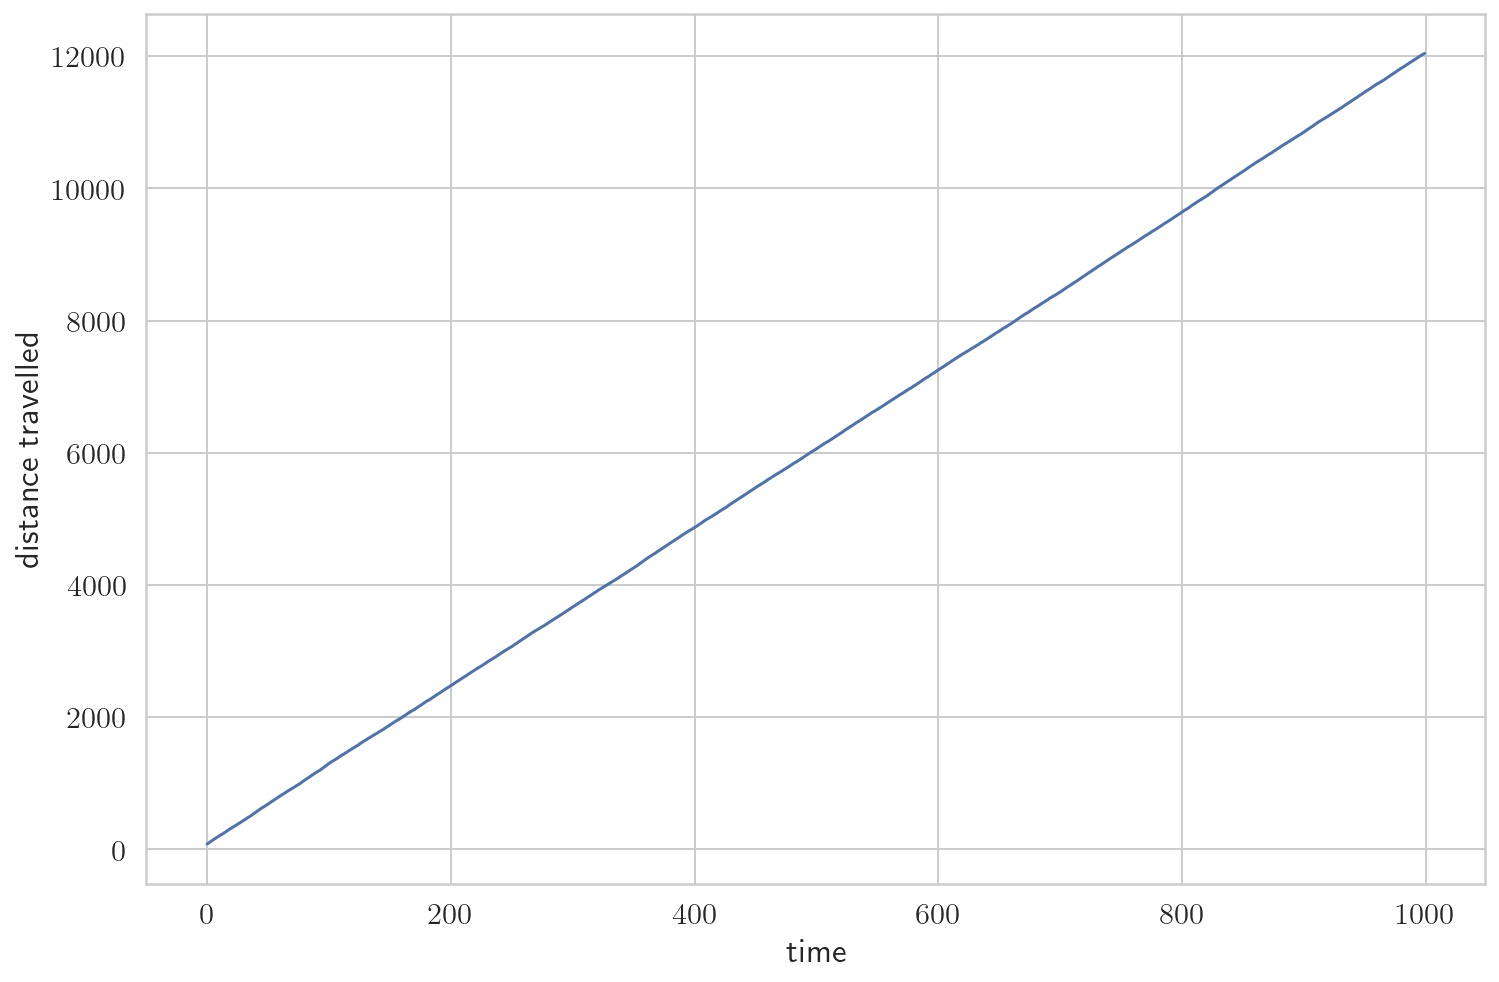

In [4]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(0, 1000), X)
plt.xlabel('time')
plt.ylabel('distance travelled')
plt.show()

Видим, что зависимость хорошо может быть приближена линейной.

#### 1. Сведите задачу к гауссовской линейной модели (определения брать из основного курса)

Рассмотрим новую модель:
$$
X_i - X_{i - 1} = \beta_2(1 + \varepsilon_i^t), \, i=1, 2, \ldots, n, \quad X_0 = \beta_1 + \beta_2\varepsilon_0^t,
$$
$$
Y_0 = X_0 = \beta_1 + \varepsilon_0', \, Y_i = X_i - X_{i - 1} = \beta_2 + \varepsilon_i', \, i=1, \ldots, n, \quad \varepsilon_i' \sim \mathcal{N}(0, \beta_2^2\sigma^2).
$$
$$
\begin{bmatrix} Y_0 \\ \vdots \\ Y_n \end{bmatrix} = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \vdots & \vdots \\ 0 & 1 \\ 0 & 1 \end{bmatrix}\cdot \begin{bmatrix} \beta_1 \\ \beta_2 \end{bmatrix} + \begin{bmatrix} \varepsilon_0 \\ \vdots \\ \varepsilon_n \end{bmatrix}
$$

In [5]:
# тут можете пересчитать выборку, если потребуется
X_ = np.empty_like(X)
X_[0] = 0
X_[1:] = X[:-1]
Y = X - X_
print(Y[:20])

[82.0053 11.8374 12.8854 13.7544 12.2596 13.686  11.1028 13.0577 11.7081
 12.5932 11.7263 11.0626 11.0556  9.127  14.4141 10.4352 13.6411 12.0168
 13.3194 10.8539]


#### 2. Найдите оценку параметров

Укажите, чему равна матрица (Z в терминах методички) в задаче:
$$
Z = \begin{bmatrix} 1 & 0 \\ 0 & 1 \\ \vdots & \vdots \\ 0 & 1 \\ 0 & 1 \end{bmatrix},
$$
Тогда
$$
\hat{\beta} = \begin{bmatrix} \hat{\beta_1} \\ \hat{\beta_2} \end{bmatrix} = (Z^TZ)^{-1}Z^TY = \begin{bmatrix} Y_0 \\ \frac{1}{n}(Y_1 + \ldots + Y_n) \end{bmatrix}.
$$
Получим также несмещенную оценку на дисперсию
$$
\hat{(\beta_2^2\sigma^2)} = \frac{1}{(n + 1) - 2}\Vert Y - Z\hat{\beta}\Vert^2 \Rightarrow \hat{\sigma}^2 = \frac{\Vert Y - Z\hat{\beta}\Vert^2}{(n - 1)\hat{\beta_2}^2}, \quad \text{из метода моментов}
$$

И найдите параметры $\beta_1$, $\beta_2$

In [6]:
beta_1 = Y[0]
beta_2 = Y[1:].mean()
print(f'beta_1 = {beta_1}')
print(f'beta_2 = {beta_2}')

beta_1 = 82.0053
beta_2 = 11.970782982982984


*Ошибкой* или *остатком* называют разность между наблюдаемым значением целевой величины и предсказанием модели на основе соответствующих признаков. Проверьте, насколько точна модель при помощи подсчёта ошибок. Выведите сами ошибки на график и проанализируйте его.

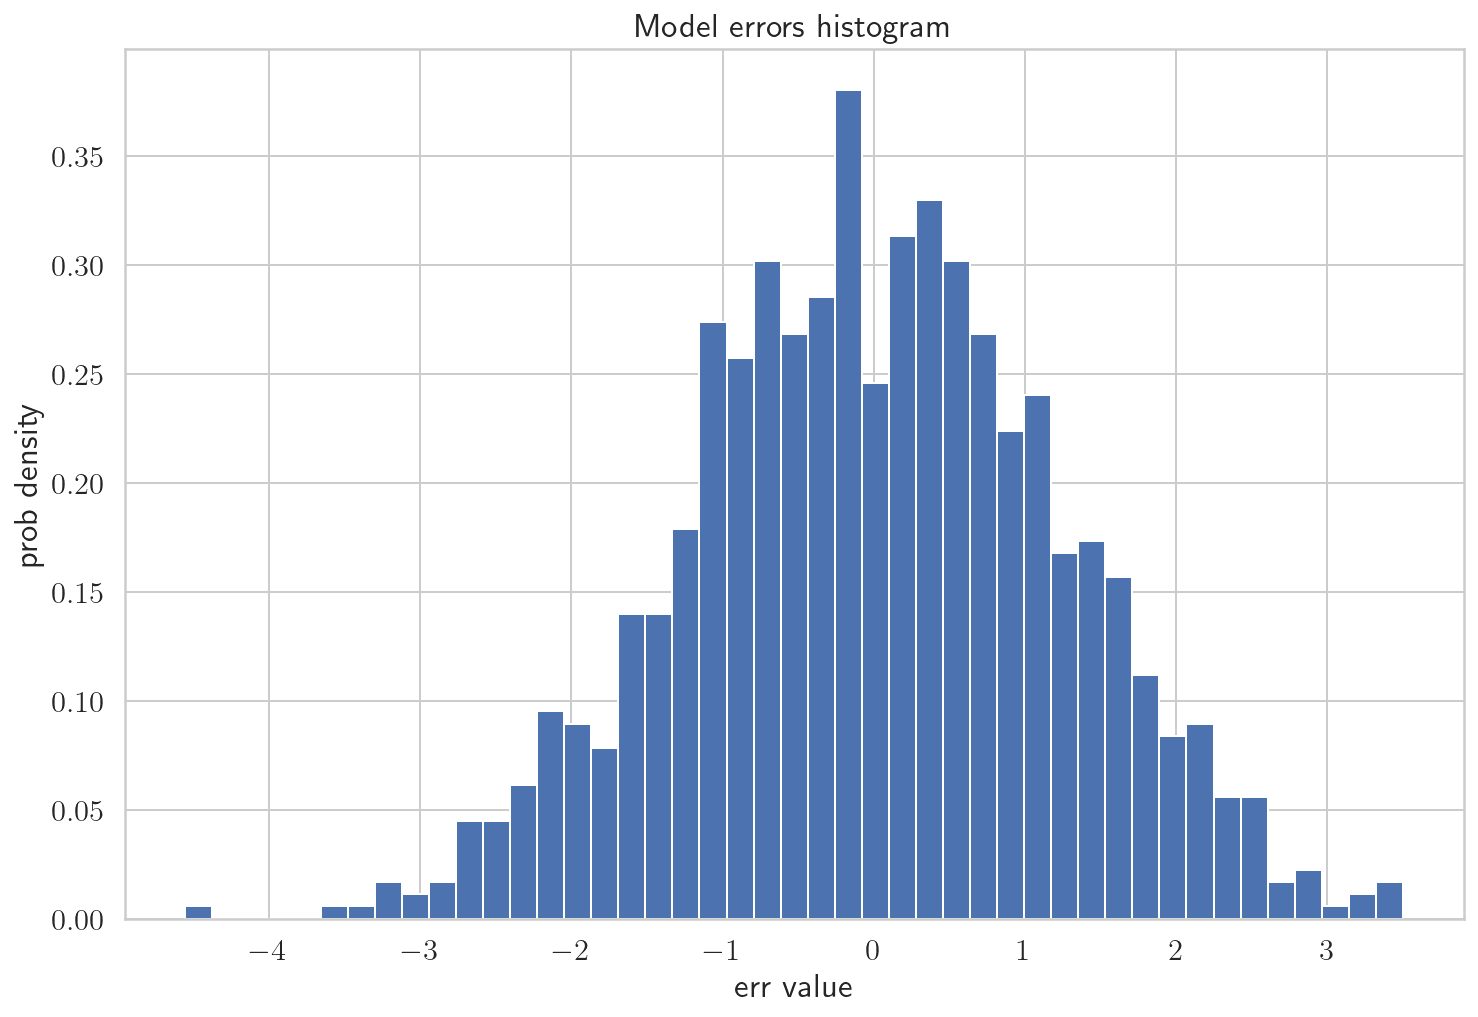

In [7]:
grid = np.arange(N)
values_theory = np.zeros_like(Y)
values_theory[0] = beta_1
values_theory[1:] = beta_2
err = Y - values_theory
#print(f'MSE = {err.mean()}')

plt.figure(figsize=(12, 8))
plt.title('Model errors histogram')
plt.xlabel('err value')
plt.ylabel('prob density')
plt.hist(err, bins=45, density=True)
plt.show()

Проверьте, что ошибка нормальна. Для этого можно использовать QQ-plot. Если хотите, можете использовать критерии нормальности

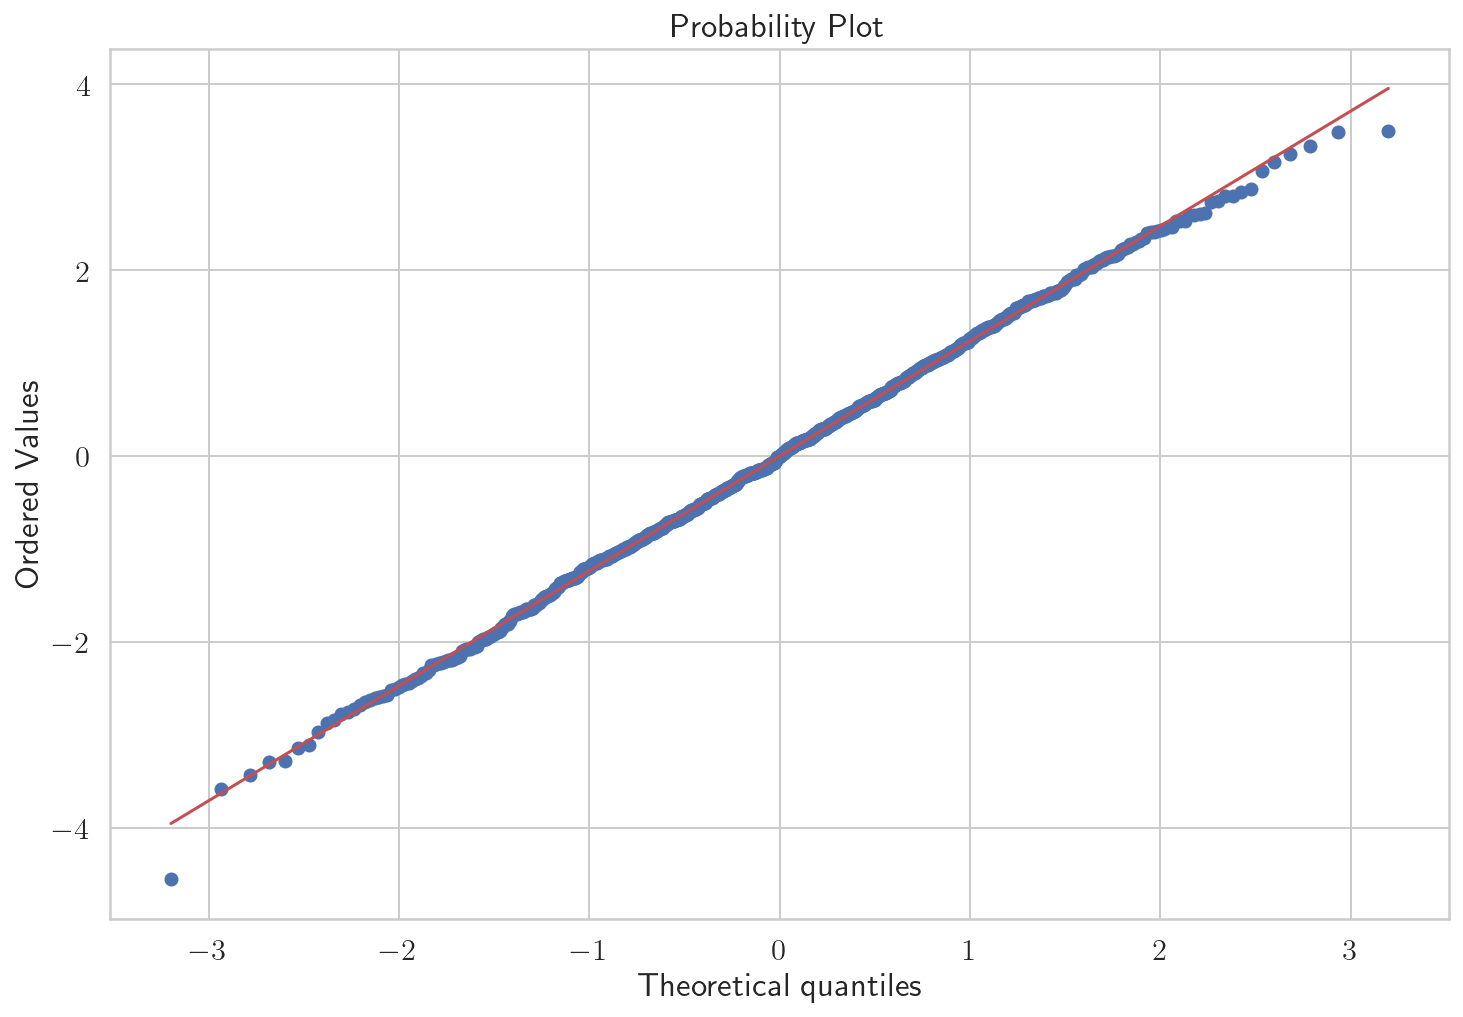

In [8]:
plt.figure(figsize=(12, 8))
_ = sps.probplot(err, dist=sps.norm(), plot=plt)
plt.show()

Видим, что QQ-plot идеально ложится на прямую, т.е. действительно ошибка нормальна.

Бонусная часть (+5 баллов):

Возможно измерения в задаче содержат разные аномалии, что плохо скажется на оценке наименьших квадратов. Попробуйте применить знания из предыдущей домашки о робастных оценках и построить оценку с BP выше нуля. Такие методы называются "робастной регрессией", но определение M-оценки в них то же, что и в обычной робастной статистике.

#### 3. Оцените дисперсию ошибки показаний датчика.

Найдите оценку дисперсии ошибка приращения расстояния $\varepsilon_i$. По ней найдите оценку дисперсию ошибки отсчёта времени $\varepsilon_i^t$.

In [9]:
print(f'variance estimation = {(err**2).sum()/((N - 1)*(beta_2)**2)}')

variance estimation = 0.010633090525597827


Дисперсия ошибки $\varepsilon_i$ равна $\frac{1}{n - 1}\Vert Y - Z\hat{\beta}\Vert^2$

In [11]:
print(f'variance estimation = {(err**2).sum()/((N - 1))}')

variance estimation = 1.5237180999706548


#### 4. Измерьте качество модели

In [20]:
y_mean = Y.mean()
err_var_t = Y.var()
err_var = (err**2).sum()/((N - 1))

print(f'R = {1 - (err_var/err_var_t)}')

R = 0.7627391952785353


**Вывод:** видим, что модель неплохо описывает реальность

## Задача 2 (5 баллов)

Непараметрическая регрессия и метод Надарая-Ватсона.

Иногда вытаскивать информативные признаки из данных сложно, а регрессию делать хочется. Тогда можно построить нечто похожее на ядерную оценку плотности, но для регрессионной задачи. Она основана на вычислении значения в новой точке по значениям в соседних точках (похожее Вы видели на курсе машинного обучения, но для классификации и без статистики).

Изучите формулу Надарая-Ватсона из статьи на википедии: https://en.wikipedia.org/wiki/Kernel_regression

1) Сгенерируйте выборку для линейной регрессии руками (использовать реальные данные может быть нецелесообразно из-за проблем с визуализацией результата и проклятия размерностей).

Пусть в модели будет одна фича $x$ и по ней вычисляется отклик $y = ax + b + \varepsilon$, где ошибка независима и нормальна, а параметры $a$ и $b$ выберите сами.

In [43]:
N = 100
a = 1.4
b = 30.5
sigma = 9.0
eps = sps.norm.rvs(scale=sigma, size=N)
X = np.arange(N)
Y_th = a*X + b
Y = a*X + b + eps

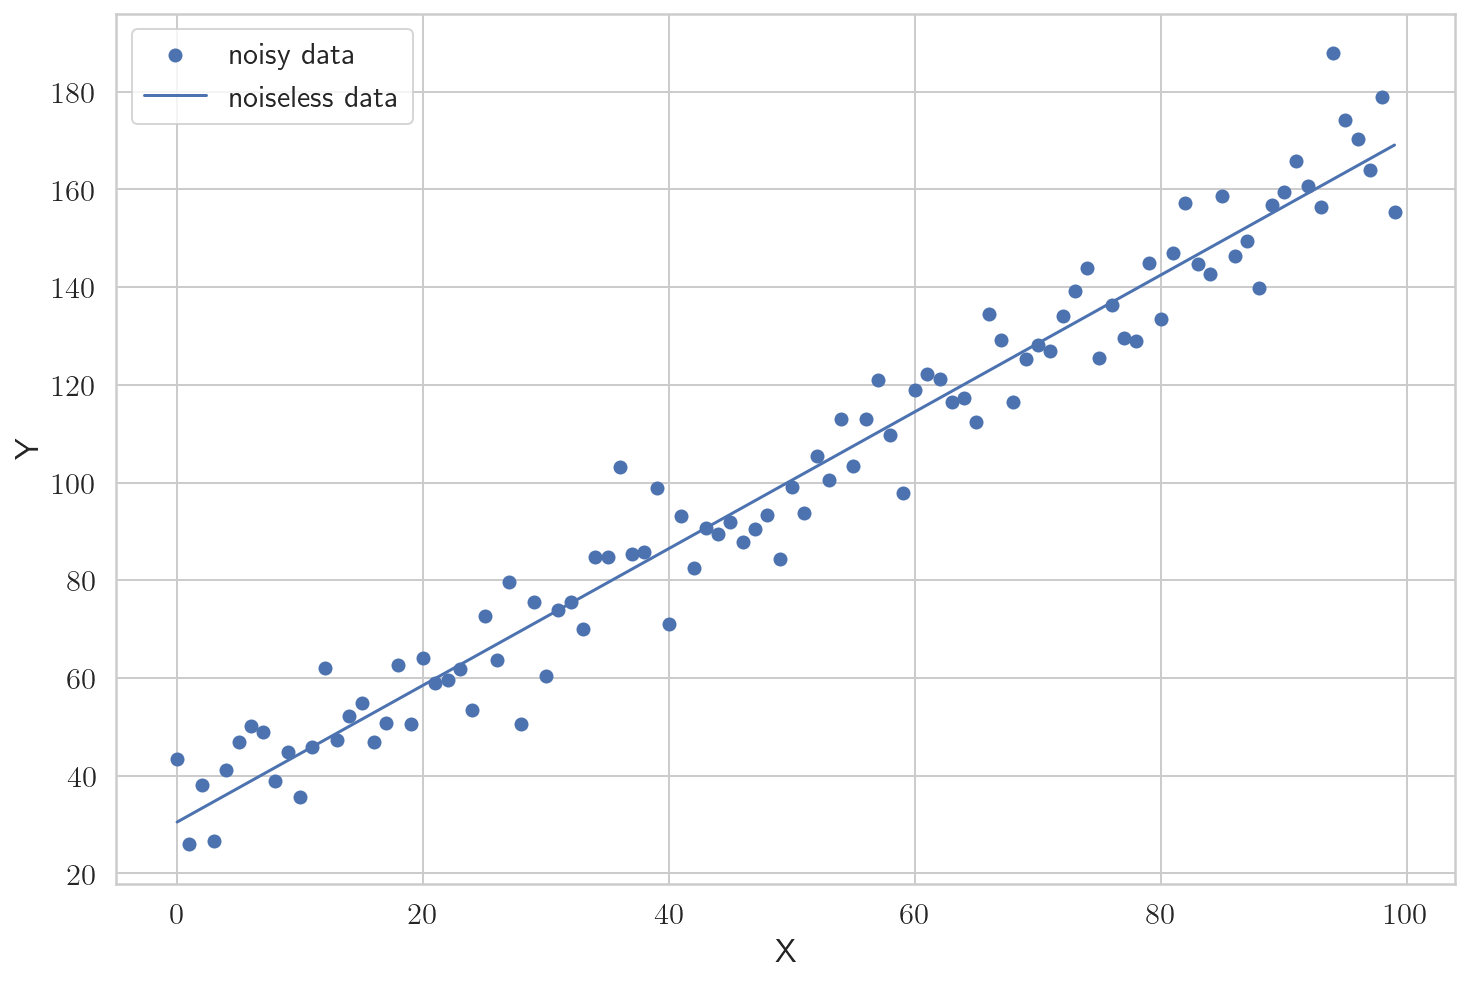

In [44]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, label='noisy data')
plt.plot(X, Y_th, label='noiseless data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

Сгенерируйте тестовую выборку тем же способом и посчитайте отклик из формулы Надарая-Ватсона для хотя бы трёх разных ядер (примеры ядер: https://en.wikipedia.org/wiki/Kernel_(statistics)). Сравните ошибки.

In [5]:
def kernel_regression(vals, kernel, h, x, y):
    ans = []
    for t in vals:
        arg = (t - x)/h
        func_applied = np.array([kernel(x) for x in arg])
        denom = (func_applied.sum())
        num = ((y*func_applied).sum())
        ans.append(num/denom)
    return np.array(ans)

In [6]:
def kernel_uniform(u):
    if (abs(u) <= 1.0):
        return 0.5
    else:
        return 0
    
def kernel_parabolic(u):
    if (abs(u) <= 1):
        return (1 - u**2)*0.75
    else:
        return 0
    
def kernel_gaussian(u):
    return sps.norm.pdf(u)

Визуализируйте Ваши предсказания (постройте кривую предсказаний по сетке x с шагом 0.01)

Uniform kernel bandwidth = 1.0, MSE = 50.79209886169555
Uniform kernel bandwidth = 5.0, MSE = 60.547141913205444
Uniform kernel bandwidth = 10.0, MSE = 67.22031827400943
Parabolic kernel bandwidth = 1.0, MSE = 1.5146129380243426e-29
Parabolic kernel bandwidth = 5.0, MSE = 53.12135379893019
Parabolic kernel bandwidth = 10.0, MSE = 61.30464769079493
Gaussian kernel bandwidth = 1.0, MSE = 34.347444137254335
Gaussian kernel bandwidth = 5.0, MSE = 60.54802302826903
Gaussian kernel bandwidth = 10.0, MSE = 75.756569560824


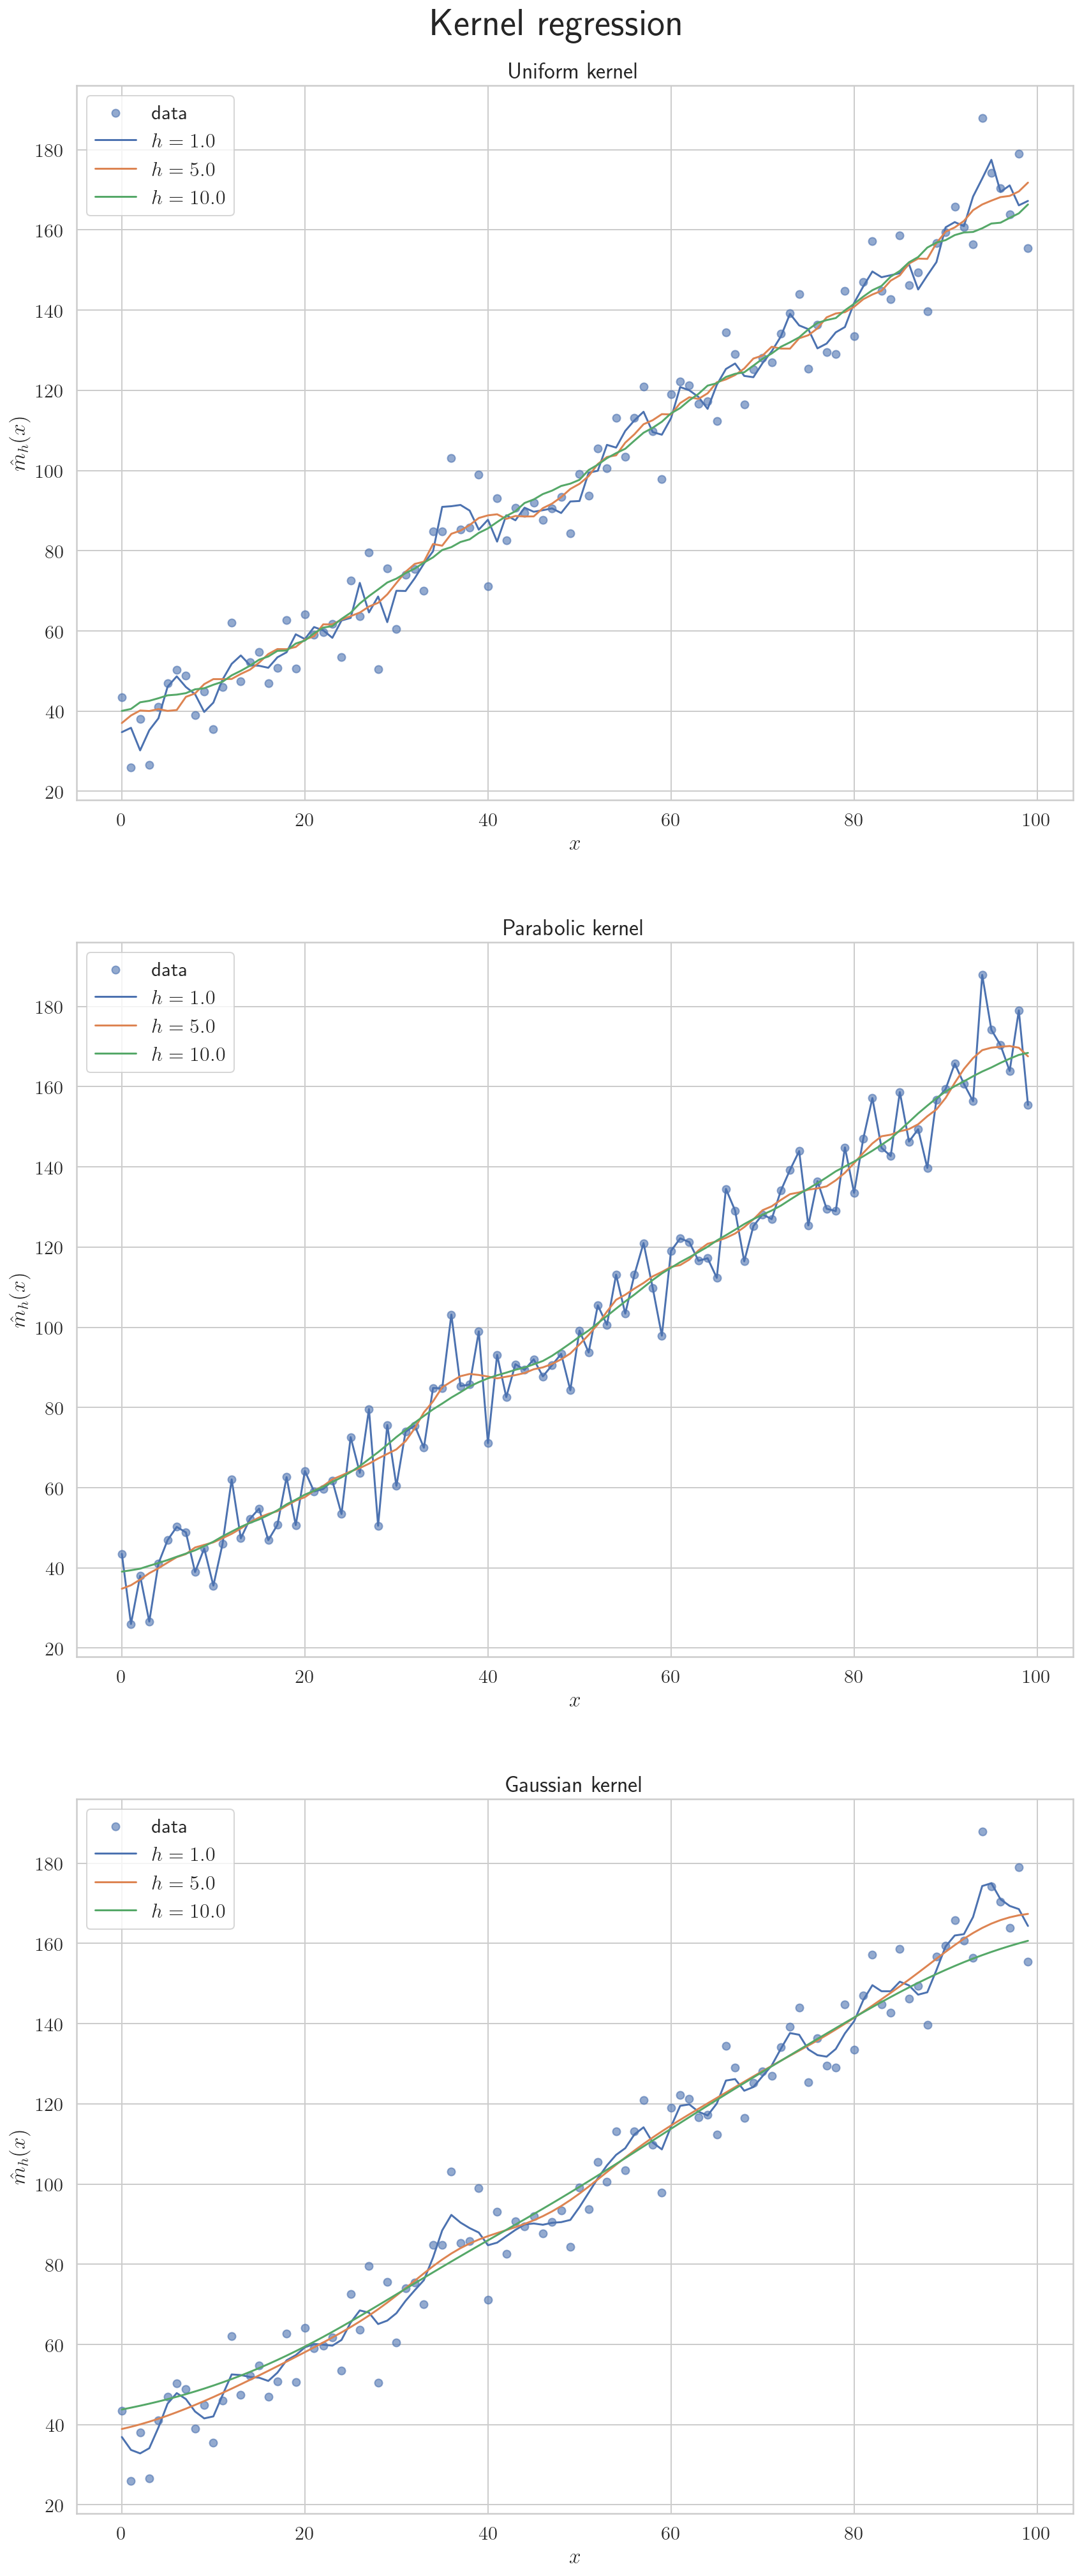

In [48]:
grid_continuous = np.arange(0, N, 1)
reg_title = np.array(['Uniform kernel', 'Parabolic kernel', 'Gaussian kernel'])
kernels = np.array([kernel_uniform, kernel_parabolic, kernel_gaussian])
bw_arr = [1.0, 5.0, 10.0]

fig, axs = plt.subplots(3, figsize=(14, 35))
fig.suptitle(r'Kernel regression', y=0.904, fontsize=30)

for jdx, ax in np.ndenumerate(axs):
    ax.set_title(reg_title[jdx], fontsize=18)
    ax.scatter(X, Y, alpha=0.6, label='data')
    for bw in bw_arr:
        regression = kernel_regression(grid_continuous, kernels[jdx], bw, X, Y)
        X_ = kernel_regression(X, kernels[jdx], bw, X, Y)
        ax.plot(grid_continuous, regression, label=r'$h = %.1f$' % (bw, ))
        print(reg_title[jdx], f'bandwidth = {bw}, MSE = {((X_ - Y)**2).mean()}')
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\hat{m}_h(x)$')
    ax.legend(fontsize=16)

plt.show()

Заметим, что мы нигде не оценивали сами параметры, но смогли решить финальную задачу -- предсказывать $y$ по $x$.

А теперь поймём, что для этого не нужна линейность.

Проделайте рассуждения выше для нелинейных зависимостей ($y = sin(kx), y = log(x), y = x^k$. Постройте графики предсказаний и сравните их с истинными функциями.

## $y = sin(kx)$

In [28]:
N = 100
k = 2
sigma = 0.9
eps = sps.norm.rvs(scale=sigma, size=N)
X = np.linspace(-3, 3, N)
Y_th = np.sin(k*X)
Y = np.sin(k*X) + eps

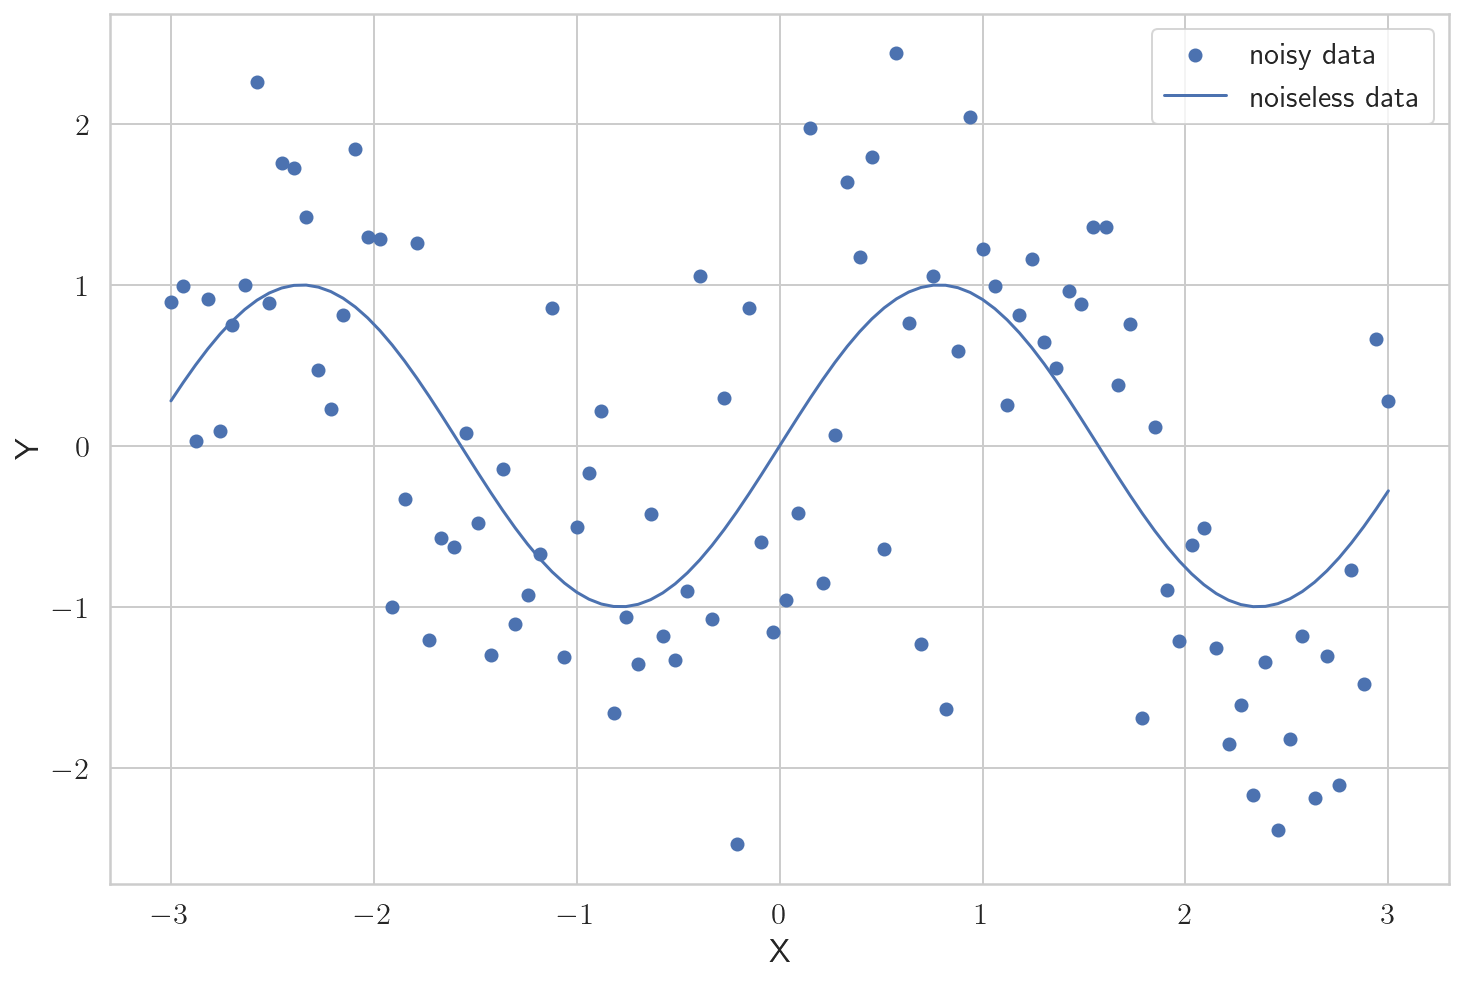

In [29]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, label='noisy data')
plt.plot(X, Y_th, label='noiseless data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

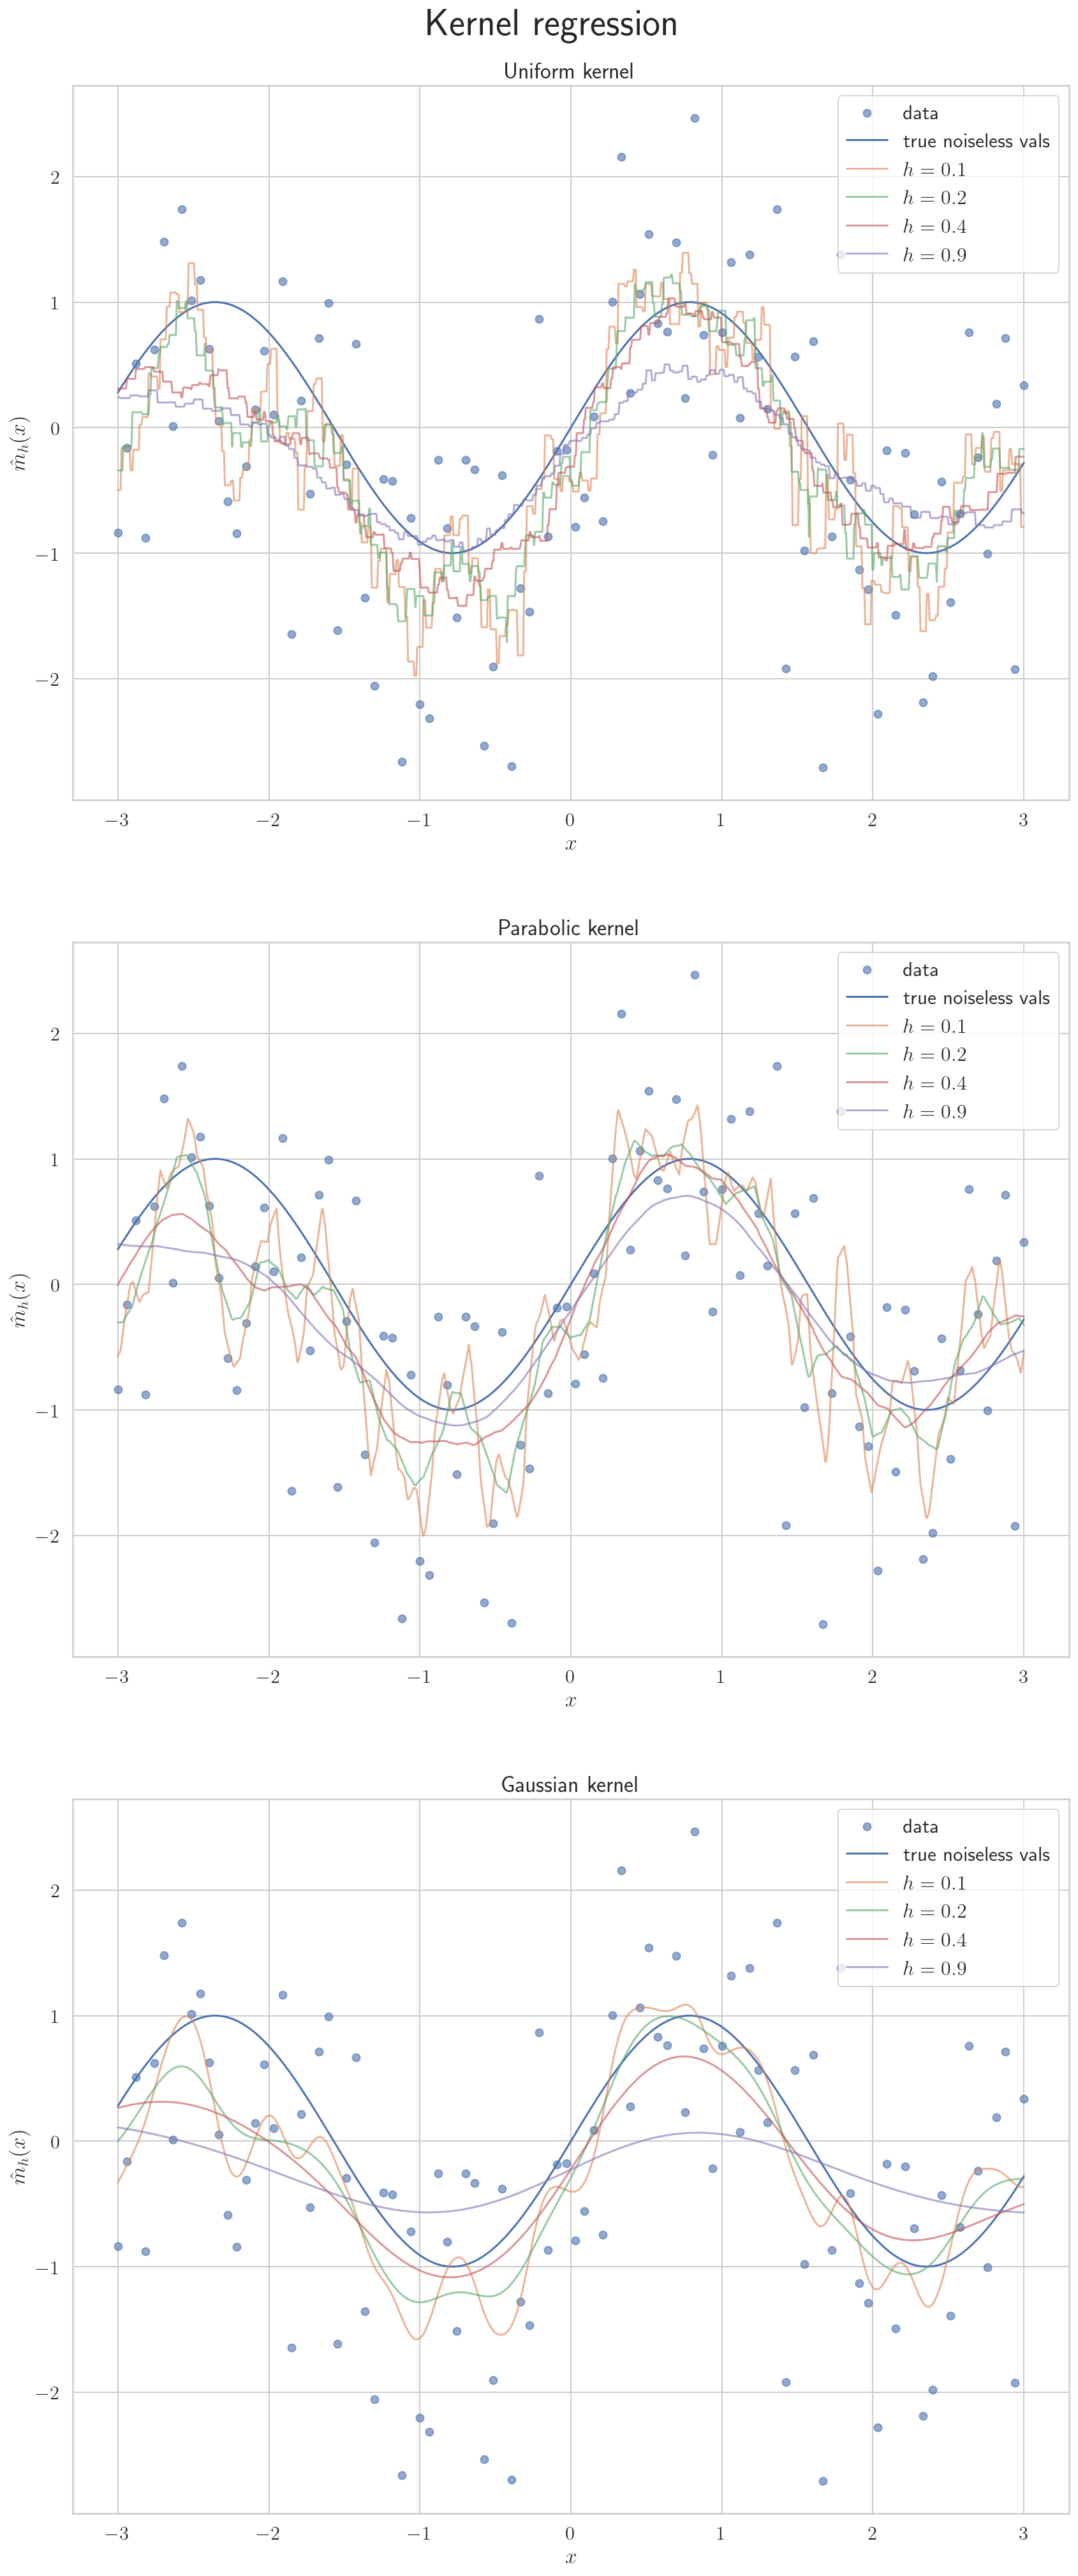

In [18]:
grid_continuous = np.linspace(-3, 3, 1000)
theory_vals = np.sin(k*grid_continuous)
reg_title = np.array(['Uniform kernel', 'Parabolic kernel', 'Gaussian kernel'])
kernels = np.array([kernel_uniform, kernel_parabolic, kernel_gaussian])
bw_arr = np.logspace(-1, -0.05, 4)

fig, axs = plt.subplots(3, figsize=(14, 35))
fig.suptitle(r'Kernel regression', y=0.904, fontsize=30)

for jdx, ax in np.ndenumerate(axs):
    ax.set_title(reg_title[jdx], fontsize=18)
    ax.scatter(X, Y, alpha=0.6, label='data')
    ax.plot(grid_continuous, theory_vals, alpha=1.0, label='true noiseless vals')
    for bw in bw_arr:
        regression = kernel_regression(grid_continuous, kernels[jdx], bw, X, Y)
        ax.plot(grid_continuous, regression, label=r'$h = %.1f$' % (bw, ), alpha=0.6)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\hat{m}_h(x)$')
    ax.legend(fontsize=16)

plt.show()

## $y = log(x)$

In [33]:
N = 100
sigma = 0.6
eps = sps.norm.rvs(scale=sigma, size=N)
X = np.linspace(0.1, 5, N)
Y_th = np.log(X)
Y = np.log(X) + eps

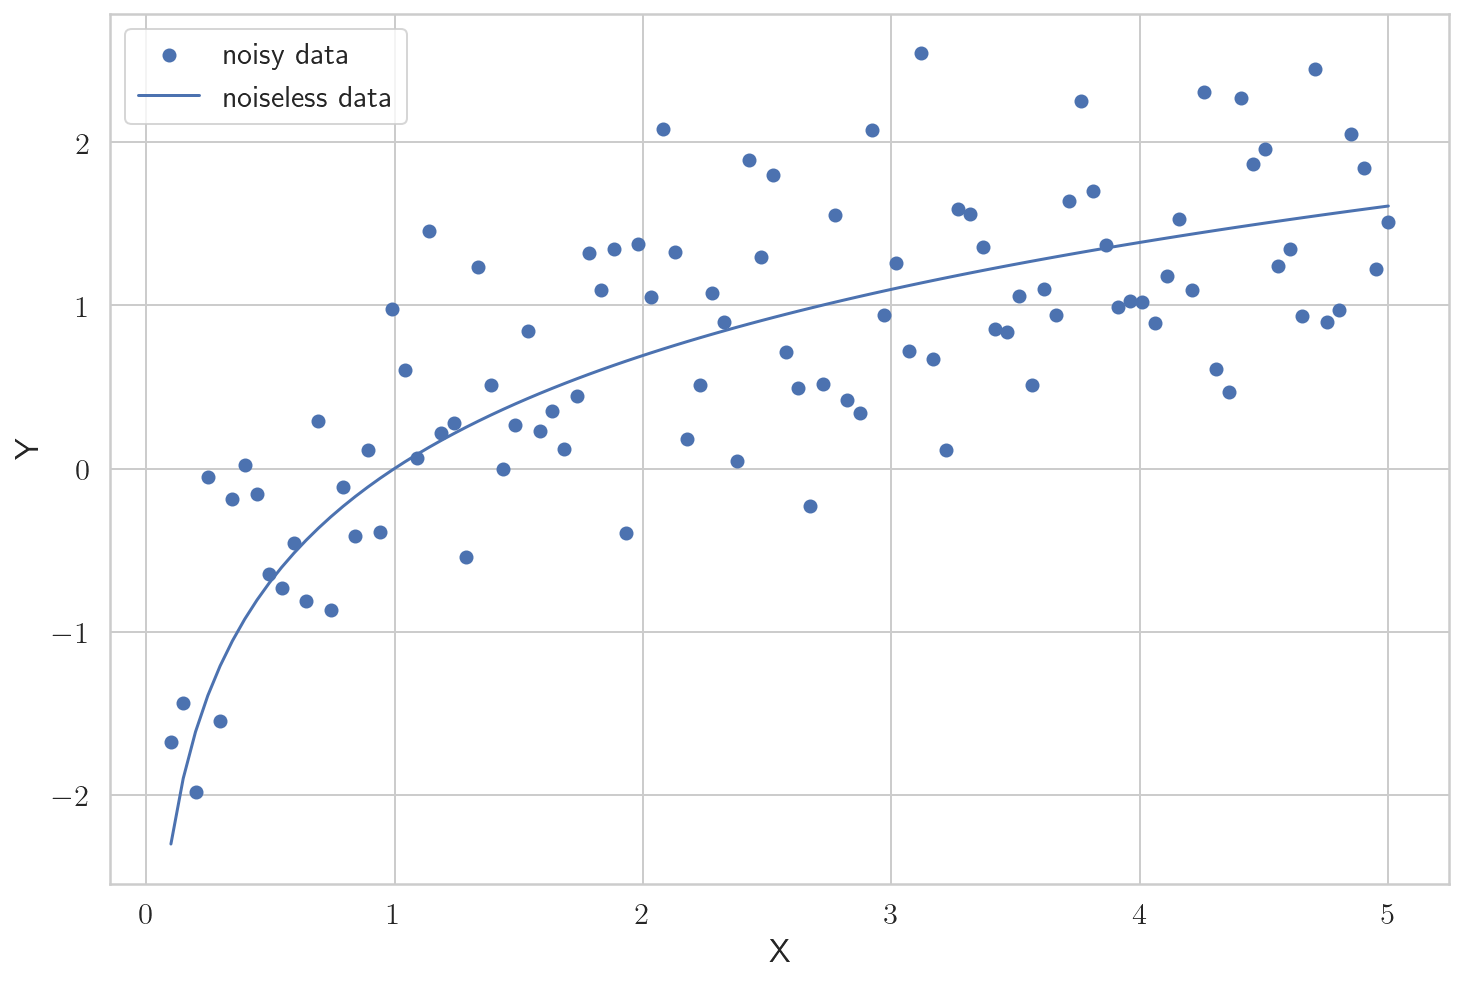

In [34]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, label='noisy data')
plt.plot(X, Y_th, label='noiseless data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

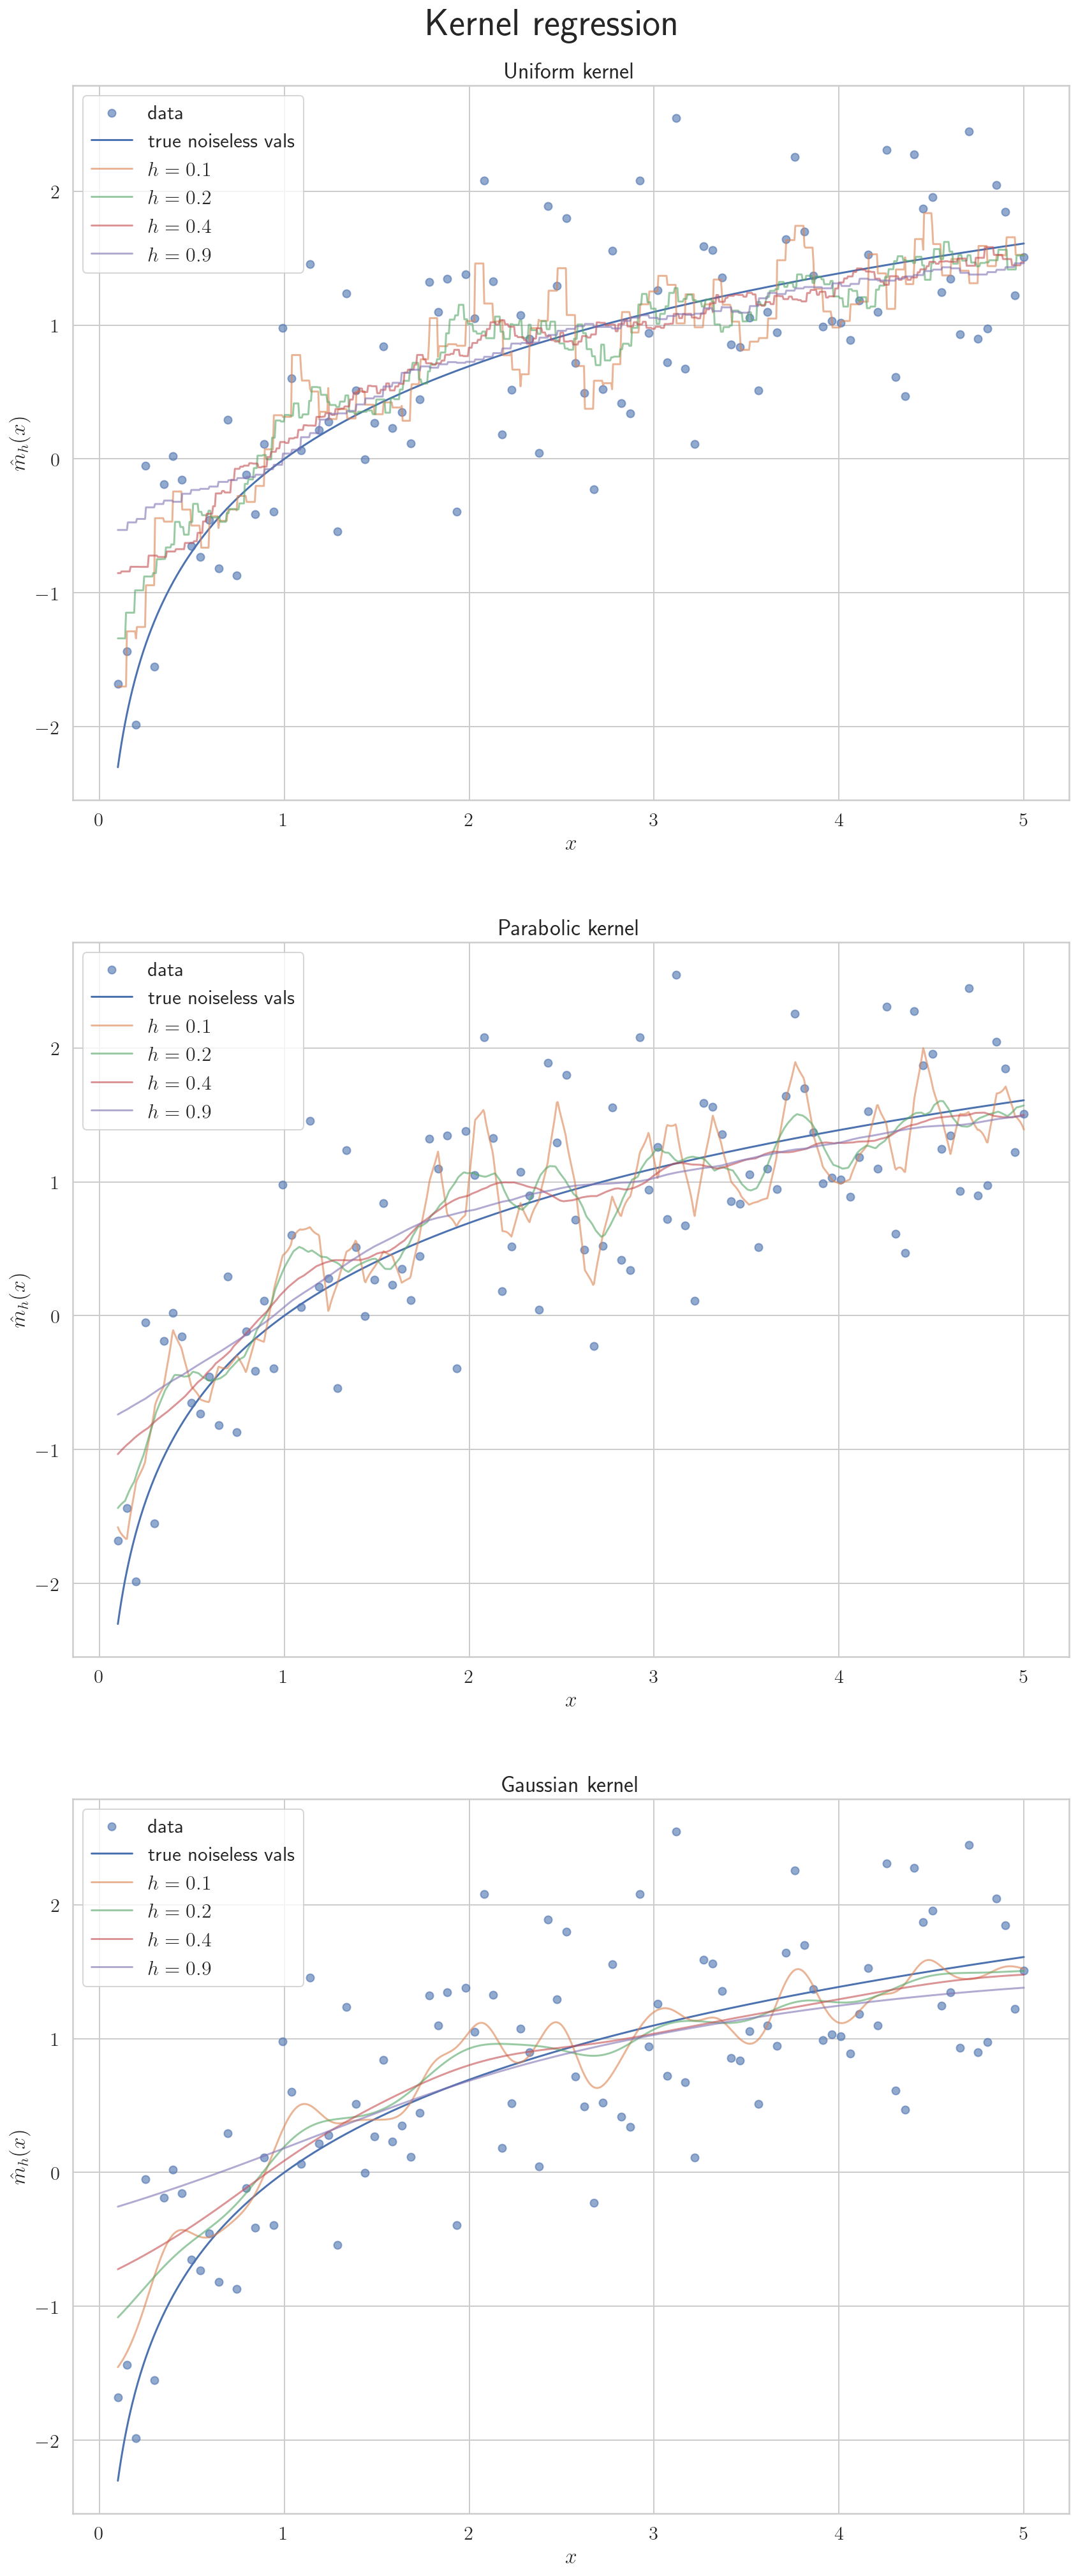

In [35]:
grid_continuous = np.linspace(0.1, 5, 1000)
theory_vals = np.log(grid_continuous)
reg_title = np.array(['Uniform kernel', 'Parabolic kernel', 'Gaussian kernel'])
kernels = np.array([kernel_uniform, kernel_parabolic, kernel_gaussian])
bw_arr = np.logspace(-1, -0.05, 4)

fig, axs = plt.subplots(3, figsize=(14, 35))
fig.suptitle(r'Kernel regression', y=0.904, fontsize=30)

for jdx, ax in np.ndenumerate(axs):
    ax.set_title(reg_title[jdx], fontsize=18)
    ax.scatter(X, Y, alpha=0.6, label='data')
    ax.plot(grid_continuous, theory_vals, alpha=1.0, label='true noiseless vals')
    for bw in bw_arr:
        regression = kernel_regression(grid_continuous, kernels[jdx], bw, X, Y)
        ax.plot(grid_continuous, regression, label=r'$h = %.1f$' % (bw, ), alpha=0.6)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\hat{m}_h(x)$')
    ax.legend(fontsize=16)

plt.show()

## $y = x^k$

In [40]:
N = 100
k = 3
sigma = 25.0
eps = sps.norm.rvs(scale=sigma, size=N)
X = np.linspace(-5, 5, N)
Y_th = X**k
Y = X**k + eps

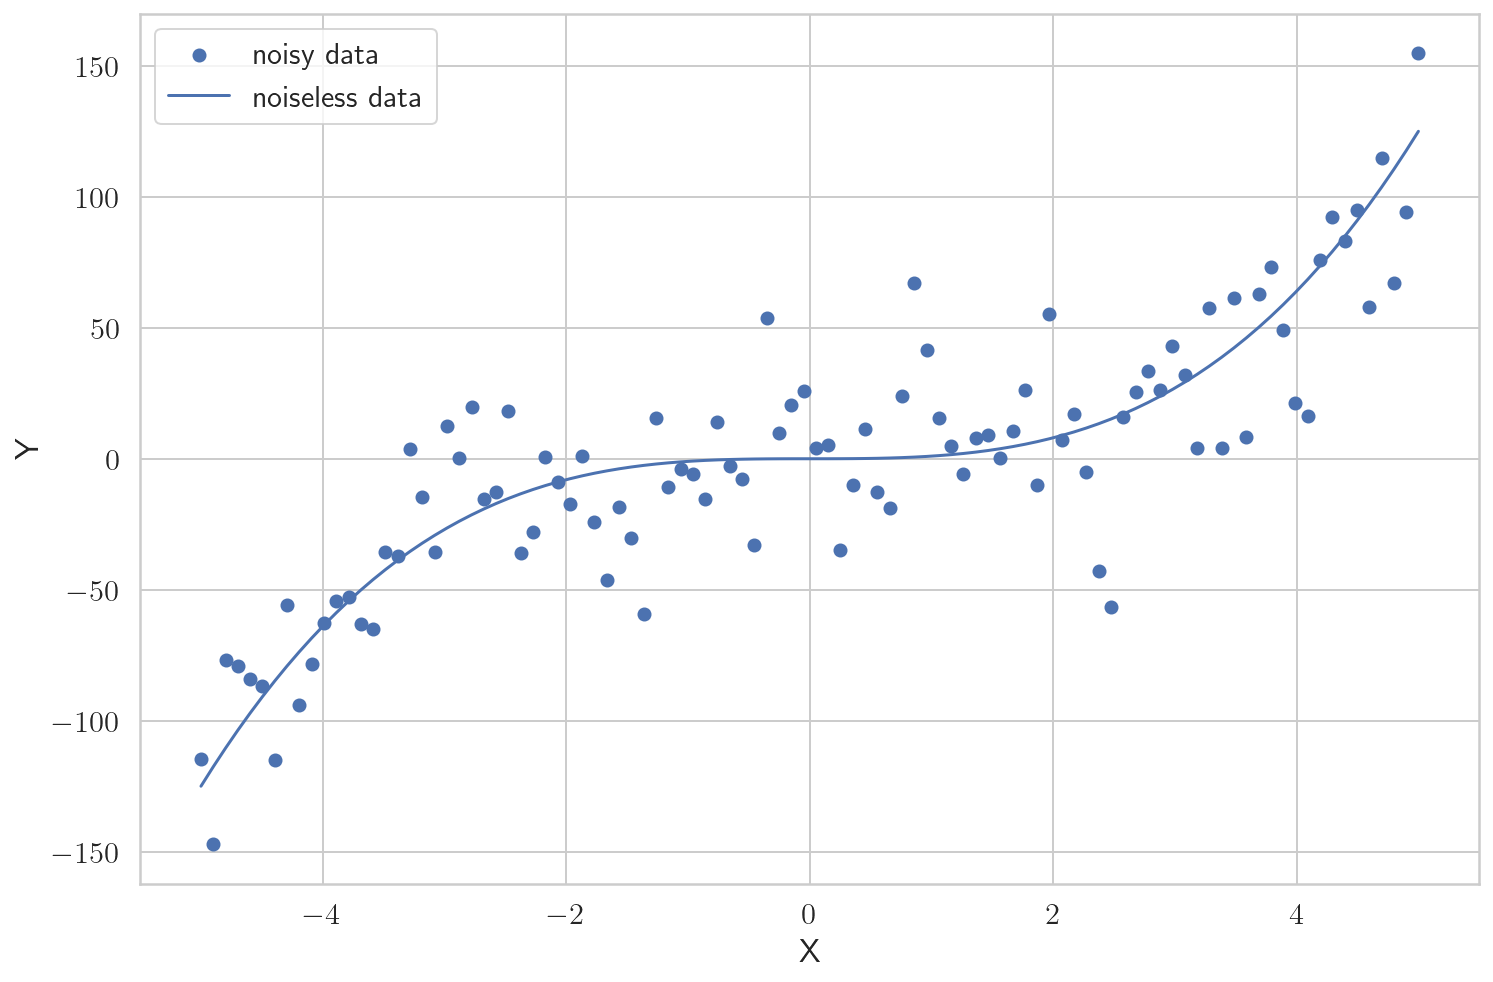

In [41]:
plt.figure(figsize=(12, 8))
plt.scatter(X, Y, label='noisy data')
plt.plot(X, Y_th, label='noiseless data')
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.show()

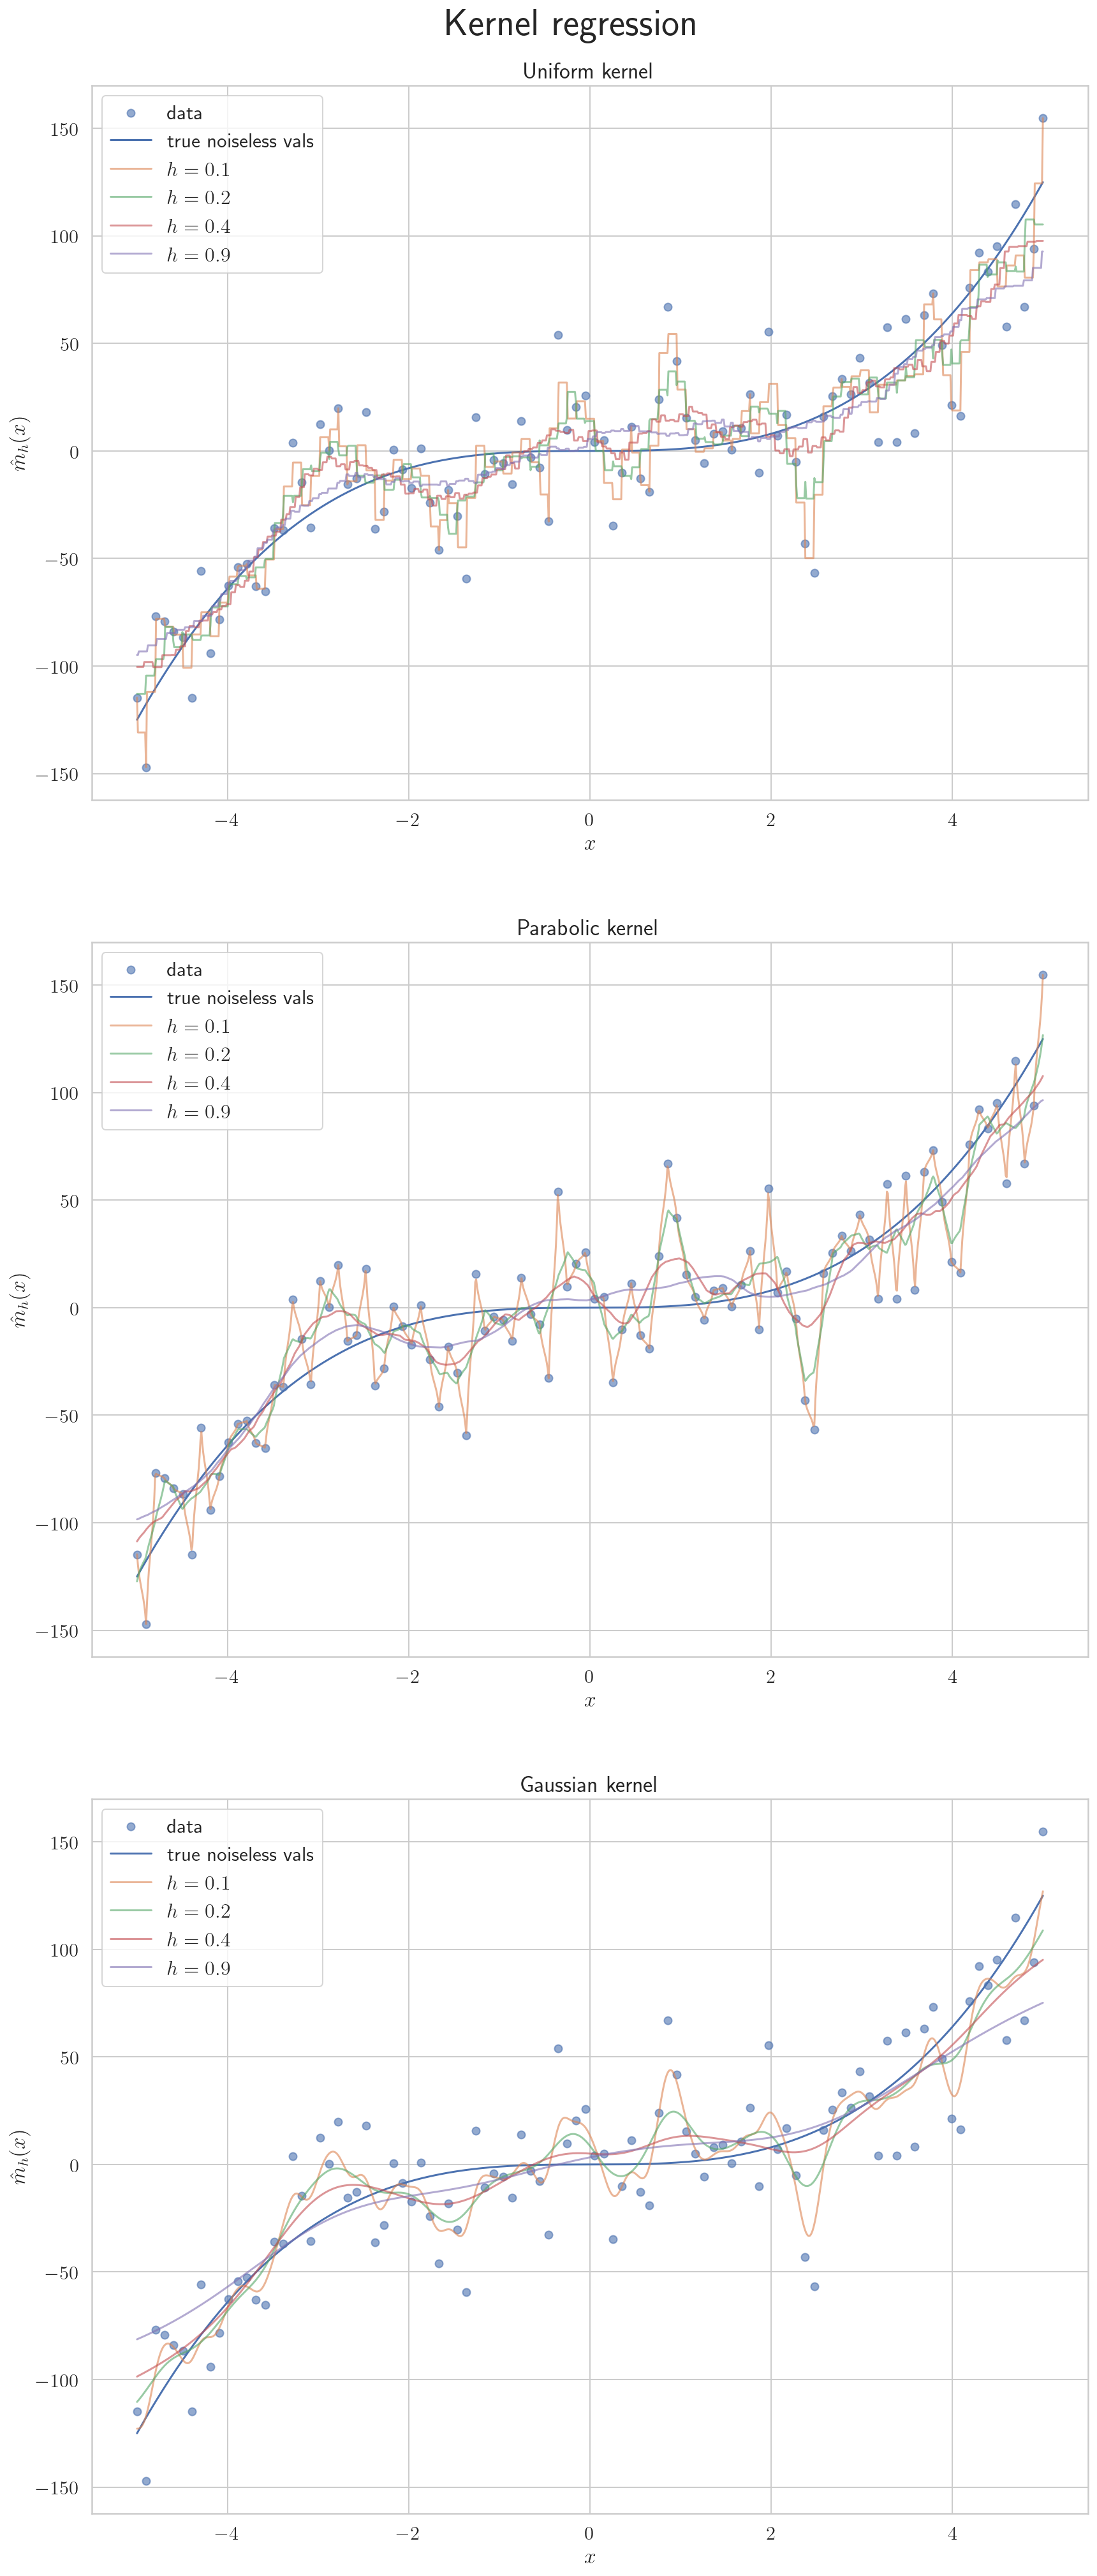

In [42]:
grid_continuous = np.linspace(-5, 5, 1000)
theory_vals = grid_continuous**k
reg_title = np.array(['Uniform kernel', 'Parabolic kernel', 'Gaussian kernel'])
kernels = np.array([kernel_uniform, kernel_parabolic, kernel_gaussian])
bw_arr = np.logspace(-1, -0.05, 4)

fig, axs = plt.subplots(3, figsize=(14, 35))
fig.suptitle(r'Kernel regression', y=0.904, fontsize=30)

for jdx, ax in np.ndenumerate(axs):
    ax.set_title(reg_title[jdx], fontsize=18)
    ax.scatter(X, Y, alpha=0.6, label='data')
    ax.plot(grid_continuous, theory_vals, alpha=1.0, label='true noiseless vals')
    for bw in bw_arr:
        regression = kernel_regression(grid_continuous, kernels[jdx], bw, X, Y)
        ax.plot(grid_continuous, regression, label=r'$h = %.1f$' % (bw, ), alpha=0.6)
    ax.set_xlabel(r'$x$')
    ax.set_ylabel(r'$\hat{m}_h(x)$')
    ax.legend(fontsize=16)

plt.show()

**Вывод:**

Можете попробовать применить метод Надарая-Ватсона для выборки из задачи 3 и посмотреть, что получится (0 баллов)

## Задача 3 (15 баллов)

Теперь давайте попрактикуемся в решении задач на реальных данных. Мы будем анализировать рынок недвижимости 🏘. Данные возьмем из [соревнования](https://www.kaggle.com/c/house-prices-advanced-regression-techniques) на платформе kaggle. В отличие от соревнований нас будут интересовать зависимости в данных, а не более точные предсказания.

![](https://storage.yandexcloud.net/miptstats-public-files/pictures/housesbanner.png)

В частности мы будем смотреть на влияние различных признаков на стоимость дома и проверим несколько гипотез.

In [ ]:
!pip install -q gdown
!gdown https://drive.google.com/uc?id=1wphoJPm4LA3-Mo_l7TRsq9uRdXkzCJqe

In [86]:
from scipy import stats as sps

import statsmodels.formula.api as smf
import statsmodels.stats.api as sms

In [87]:
df = pd.read_csv("train.csv")

df.fillna("NA", inplace=True)
df.head()

/var/folders/rr/3rk4142n7971lnmgm098j4qw0000gn/T/ipykernel_1006/119077902.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value 'NA' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.fillna("NA", inplace=True)


Id  MSSubClass MSZoning LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL        65.0     8450   Pave    NA      Reg   
1   2          20       RL        80.0     9600   Pave    NA      Reg   
2   3          60       RL        68.0    11250   Pave    NA      IR1   
3   4          70       RL        60.0     9550   Pave    NA      IR1   
4   5          60       RL        84.0    14260   Pave    NA      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
1         Lvl    AllPub  ...        0     NA    NA          NA       0      5   
2         Lvl    AllPub  ...        0     NA    NA          NA       0      9   
3         Lvl    AllPub  ...        0     NA    NA          NA       0      2   
4         Lvl    AllPub  ...        0     NA    NA          NA       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

Можно заметить, что в данных присутствуют категориальные признаки, которые при этом не лишены порядка.

Вспомните курс машинного обучения. Как можно обработать категориальные призаки, чтобы регрессионная модель была осмысленна?

Ответ: факторизовать числами от 0 до N - 1, где N - количество категорий

In [92]:
print(df.dtypes.to_string())

Id                int64
MSSubClass        int64
MSZoning         object
LotFrontage      object
LotArea           int64
Street           object
Alley            object
LotShape         object
LandContour      object
Utilities        object
LotConfig        object
LandSlope        object
Neighborhood     object
Condition1       object
Condition2       object
BldgType         object
HouseStyle       object
OverallQual       int64
OverallCond       int64
YearBuilt         int64
YearRemodAdd      int64
RoofStyle        object
RoofMatl         object
Exterior1st      object
Exterior2nd      object
MasVnrType       object
MasVnrArea       object
ExterQual        object
ExterCond        object
Foundation       object
BsmtQual         object
BsmtCond         object
BsmtExposure     object
BsmtFinType1     object
BsmtFinSF1        int64
BsmtFinType2     object
BsmtFinSF2        int64
BsmtUnfSF         int64
TotalBsmtSF       int64
Heating          object
HeatingQC        object
CentralAir      

In [95]:
cat_columns = df.select_dtypes(['object']).columns
df[cat_columns] = df[cat_columns].apply(lambda x: pd.factorize(x)[0])

### Визуализируйте данные

Перед тем, как начать использовать линейные модели необходимо убедиться в том, что столбцы признаков не слишком коллинеарны. Для этого можно использовать [корреляцию Пирсона](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient#For_a_sample). Используя ``sns.heatmap`` постройте "тепловую карту" попарных корреляций признаков. Для того, чтобы увидеть числовые значения корреляций используйте ``annot=True``. Сделайте размер графика алекватным, например, ``figsize=(11, 10)``.

Какие признаки Вам кажутся самыми полезными? Выберите 9-10 признаков (пока на основании логики) и визуализируйте только их.

Можете использовать предложенные нами:

useful_columns = [
    "OverallQual",
    "GrLivArea",
    "ExterQual",
    "KitchenQual",
    "GarageArea",
    "PoolArea",
    "BsmtQual",
    "TotalBsmtSF",
    "GarageFinish",
    "SalePrice"
]

In [96]:
useful_columns = ["OverallQual", "GrLivArea", "ExterQual",
                  "KitchenQual", "GarageArea", "PoolArea",
                  "BsmtQual", "TotalBsmtSF", "GarageFinish", "SalePrice" ]
filtered_df = df[useful_columns]

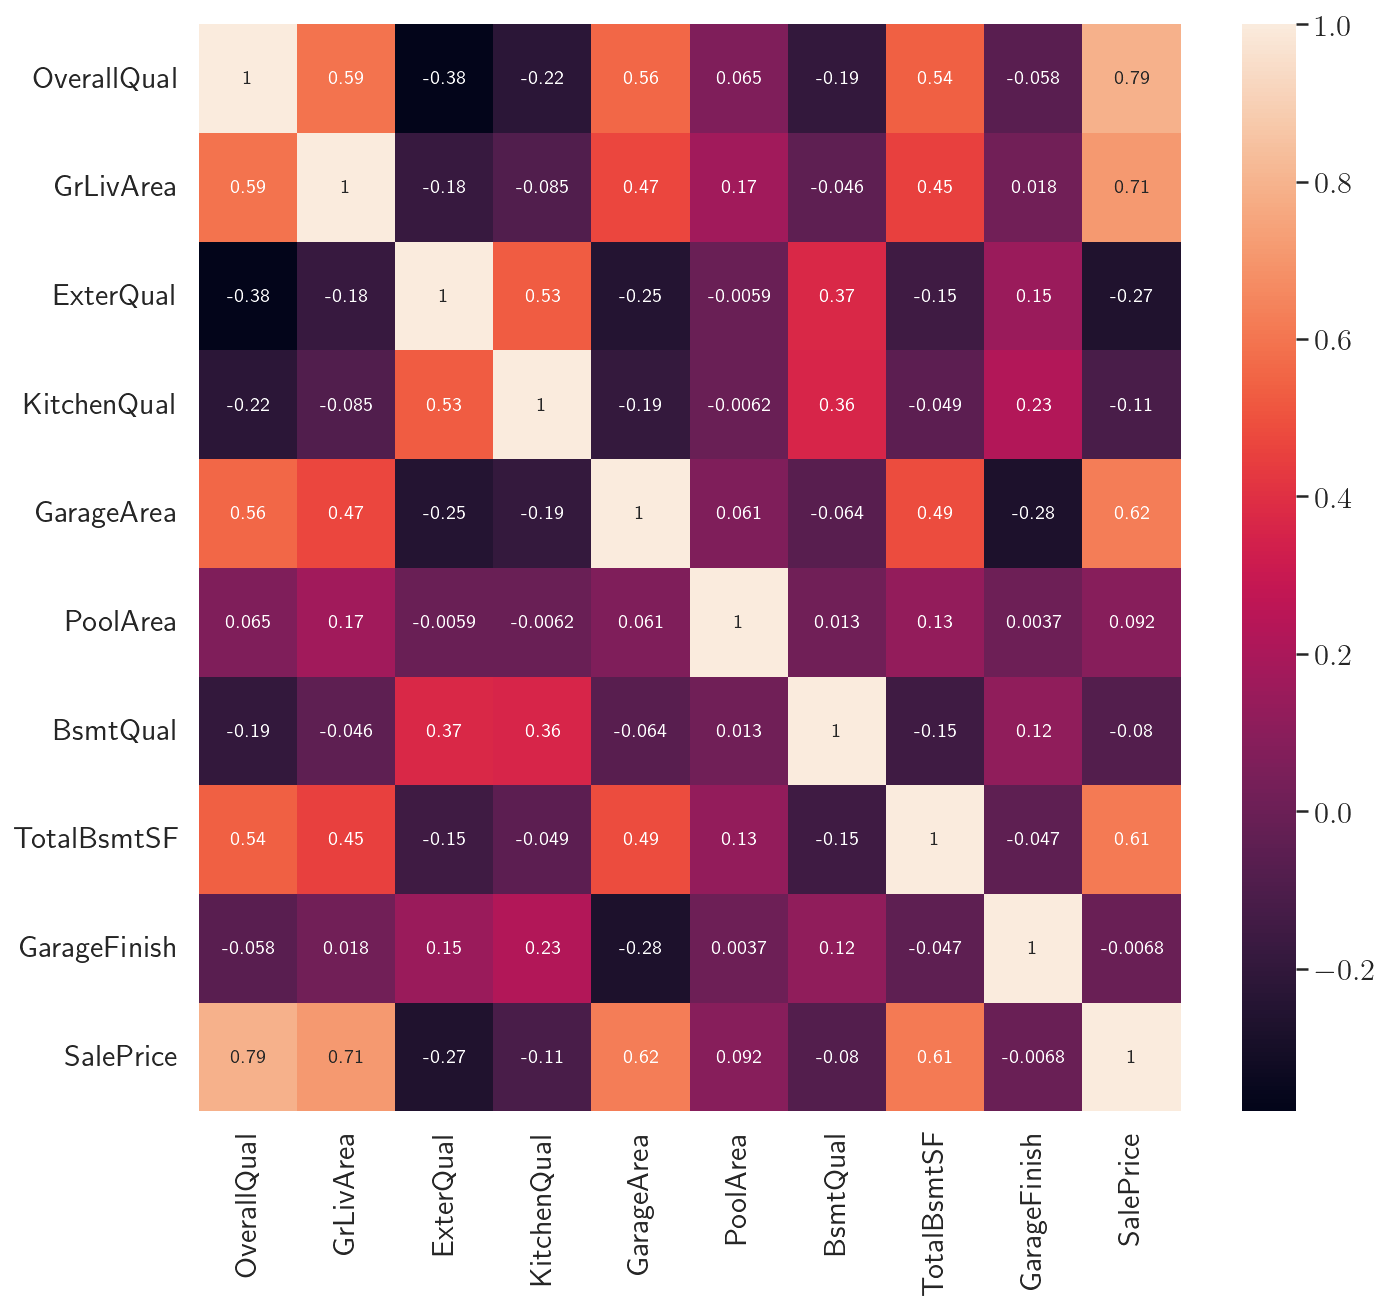

In [101]:
plt.figure(figsize=(11, 10))
sns.heatmap(filtered_df.corr(), annot=True)
plt.show()

Изучите карту и сделайте по ней выводы о зависимости в данных ($|r_{XY}| > 0.9$). А чем плохи зависимые признаки? Для ответа на последний вопрос напишите чему равно аналитическое решение задачи регрессии.

**Ответ:** поскольку решение задачи регрессии задается в виде $w^* = (X^TX)^{-1}X^TY$, при наличии зависимостей между столбцами $X$ возникнут трудности с обращением матрицы $X^TX$, которая окажется плохо обусловленной, из-за чего очень чуствительной к шумам. В нашем случае, как видно выше, сильно скоррелированных признаков нет.

Удалите, если требуется, один из двух скоррелированных признаков в ячейке ниже.

Давайте подробнее изучим взаимодействие признаков. Построим матрицу. На диагонале $a_{ii} = d_i$ этой матрицы построим гистограммы для $i$-го признака. На остальных позициях $a_{ij}$ будут располагаться scatterplot в осях признака $i$ по $x$ и признака $j$ по $y$. Для этого можно использовать метод из pandas ``pd.plotting.scatter_matrix``.

array([[<Axes: xlabel='OverallQual', ylabel='OverallQual'>,
        <Axes: xlabel='GrLivArea', ylabel='OverallQual'>,
        <Axes: xlabel='ExterQual', ylabel='OverallQual'>,
        <Axes: xlabel='KitchenQual', ylabel='OverallQual'>,
        <Axes: xlabel='GarageArea', ylabel='OverallQual'>,
        <Axes: xlabel='PoolArea', ylabel='OverallQual'>,
        <Axes: xlabel='BsmtQual', ylabel='OverallQual'>,
        <Axes: xlabel='TotalBsmtSF', ylabel='OverallQual'>,
        <Axes: xlabel='GarageFinish', ylabel='OverallQual'>,
        <Axes: xlabel='SalePrice', ylabel='OverallQual'>],
       [<Axes: xlabel='OverallQual', ylabel='GrLivArea'>,
        <Axes: xlabel='GrLivArea', ylabel='GrLivArea'>,
        <Axes: xlabel='ExterQual', ylabel='GrLivArea'>,
        <Axes: xlabel='KitchenQual', ylabel='GrLivArea'>,
        <Axes: xlabel='GarageArea', ylabel='GrLivArea'>,
        <Axes: xlabel='PoolArea', ylabel='GrLivArea'>,
        <Axes: xlabel='BsmtQual', ylabel='GrLivArea'>,
        <Axes: x

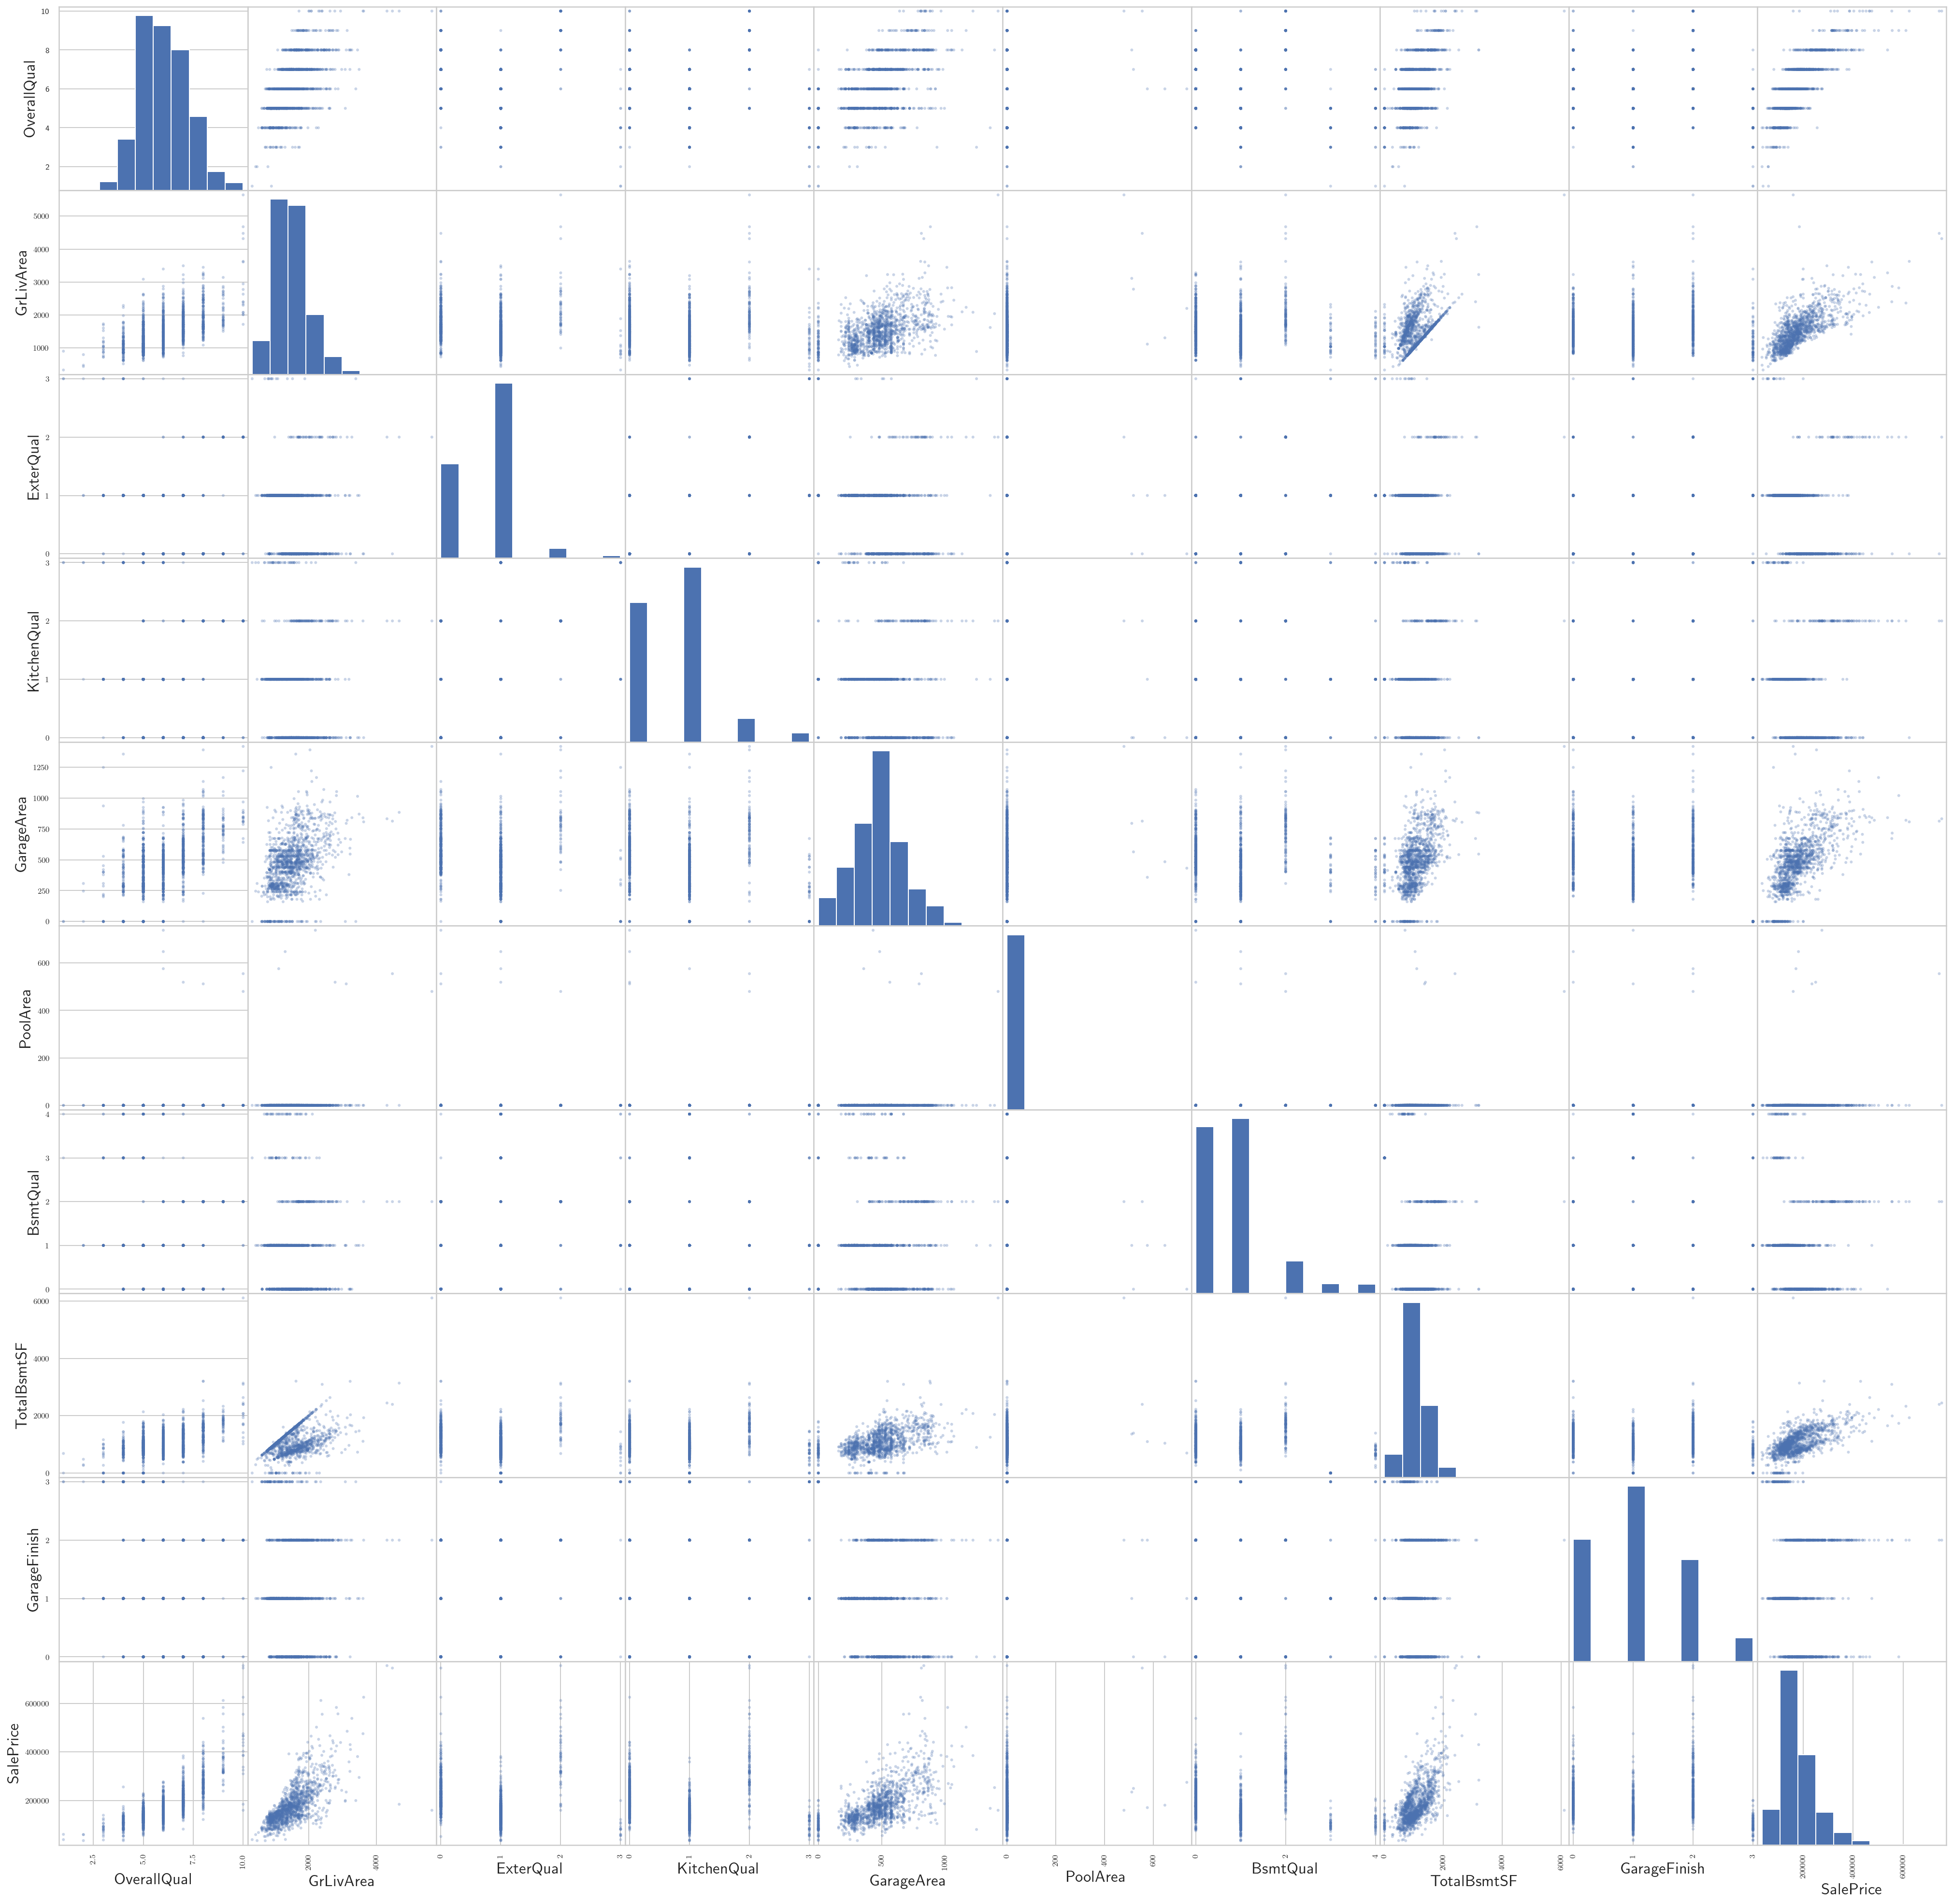

In [111]:
pd.plotting.scatter_matrix(filtered_df, alpha=0.3, figsize=(35, 35))

Сделайте вывод о данных. Опишите, нужна ли регуляризация и почему?

### Как пользоваться линейными моделями

Как можно догадаться, на практике никто не пишет заново свои линейные модели. Для машинного обучения часто используют библиотеку scikit learn, для аналитики statsmodels. С первой вы познакомитесь (или уже познакомились) на курсе по ML, мы же сконцентрируемся на второй.

Итак, библиотека statsmodels состоит из множества реализованных критериев и, как ни странно, статистических моделей. Основным плюсом является то, что нам не нужно реализовывать критериии вручную, все сделано за нас (это не значит что думать не надо!).

Начнем с линейной модели: для того, чтобы ее создать понадобится лишь одна строка.  Как видно в ячейке ниже мы задаем формулу того, какую модель мы хотим получить. В данном случае мы хотим предсказать ``SalePrice`` по взвешенной сумме из остальных признаков.

In [108]:
formula = "SalePrice ~ " + " + ".join(useful_columns[:-1])

print(formula)

SalePrice ~ OverallQual + GrLivArea + ExterQual + KitchenQual + GarageArea + PoolArea + BsmtQual + TotalBsmtSF + GarageFinish


Теперь эту формулу мы просто передаем в модель, а так же подаем ей данные. В формуле написаны имена колонок из ``filtered_df``.

In [109]:
simple_model = smf.ols(formula, data=filtered_df)

fitted_simple_model = simple_model.fit()

print(fitted_simple_model.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     524.2
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        12:45:40   Log-Likelihood:                -17487.
No. Observations:                1460   AIC:                         3.499e+04
Df Residuals:                    1450   BIC:                         3.505e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.138e+05   5751.208    -19.785   

### Гетероскедастичность ошибки

**гомоскедастичностью** называют свойство одинаковости дисперсии и независимость остатков модели.

Оценка, полученная с помощью гауссовской линейной модели будет справедлива лишь при выполнении условия гомоскедастичности остатков. Для проверки на гомоскедастичность часто используют критерий Бройша — Пагана. Мы не будем вдаваться в детали и доказательство того, что критерий валидный и работает правильно. Итак, критерий Бройша — Пагана проверяет нулевую гипотезу о гомоскедастичности распределения данных против альтернативы, то есть гетероскедастичности. Если нулевая гипотеза отвергается то можно сказать, что данные распределены ГЕТЕРОскедастично. Мы этого не хотим.

Критерий реализован с помощью функции ``sms.diagnostic.het_breuschpagan``. Документацию можно найти [здесь](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.het_breuschpagan.html).

Остатки модели можно из поля ``fitted_model.resid``, а параметры из ``fitted_model.model.exog``.

Нас интересует p-value для множителя Лагранжа.

В ячейке ниже получите уровень достигаемой значимости для критерия Бройша — Пагана.

In [117]:
p_val_het = sms.diagnostic.het_breuschpagan(resid=fitted_simple_model.resid,
                                            exog_het=fitted_simple_model.model.exog)[1]

print(f"p-value simple: {p_val_het}")

p-value simple: 1.2430559231770068e-103


Пока не вдаваясь в проверку гипотез просто будем считать, что критерий точно проверяет условие гомоскедастичности.

Отвергается ли гипотеза о гомоскедастичности остатков (определение из будущего: гипотеза отвергается, если pvalue < 0.05 и это значит, что её утверждение полагается неверным)? Что это означает?

**Ответ:** Отвергается, значит остатки гетероскедастичны, т.е. предположения о равных дисперсиях ошибок измерений заведомо неверны. Таким образом мы хоть и получили несмещённую оценку, никакой гарантии того, что дисперсия отклонений будет минимальна, нет.

В случаях, когда распределения остатков не является гомоскедастичном оценка по-прежнему остается несмещенной, однако стоит сделать некоторую поправку, на более высокую дисперсию. Поэтому значения F-критериев и t-критериев для коэффициентов стоит пересмотреть. Для таких случаев существует достаточно много различных поправок, одно из семейств таких поправок называется поправки Уайта на гетероскедастичность. Ниже мы попробуем использовать одну из поправок.

Для этого, в ячейке ниже, обучите линейную модель, но на этот раз передайте в метод ``.fit`` аргумент ``cov_type="HC1"``.

Получите summary для такой модели.

In [118]:
simple_model_new = smf.ols(formula, data=filtered_df)

fitted_simple_model_new = simple_model_new.fit(cov_type="HC1")

print(fitted_simple_model_new.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     362.0
Date:                Tue, 26 Nov 2024   Prob (F-statistic):               0.00
Time:                        13:34:27   Log-Likelihood:                -17487.
No. Observations:                1460   AIC:                         3.499e+04
Df Residuals:                    1450   BIC:                         3.505e+04
Df Model:                           9                                         
Covariance Type:                  HC1                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept    -1.138e+05   1.35e+04     -8.446   

Проанализируйте результаты. Как изменились показатели из таблицы?

**Ответ:**

Теперь мы действительно можем оценивать то, насколько важен тот или иной признак.



Проведите отбор признаков методами с семинара. Начните с того, что выберите около 15 признаков, которые Вам кажутся разумными и отберите лучшие 3, 5 и 10 из них.

Какие признаки оказались не значимы и почему?

**Ответ:**

Теперь снова обучим новую модель только на значимых признаках и получим summary. Не забудьте про поправку Уайта!

Как изменился коэффициент $R^2$? Всегда ли бОльший $R^2$ говорит о правильной модели? Расскажите о своих рассуждениях!

**Ответ:**

### Преобразование целевого признака

Обратим свое внимание на целевую переменную. Ниже постройте гистограммы для признака ``SalePrice``. А так же для логарифма от ``SalePrice``. Сделайте это на разных картинках. Можно использовать subplot.

Какой из графиков выглядит более "Гауссовским"?

**Ответ:**

Теперь давайте снова посмотрим на распределение остатков от линейной модели. Начертим qqplot для нормального распределения и гистограмму остатков.

Как вы считаете, можно ли сказать, что распределение остатков это нормальное распределение?

**Ответ:**

Давайте обучим модель предсказывать не SalePrice, а ее логарифм. Для этого снова обновим формулу для модели. Прелесть формул в том, что в них можно использовать операции из numpy. Например можно искать зависимость не от ``PoolArea``, а от ее квадрата, то есть ``np.power(PoolArea, 2)``. Достаточно просто добавить в формулу ..." + np.power(PoolArea, 2)" и все заработает!

В ячейке ниже обучите модель предсказывать логарифм SalePrice. Получите summary этой модели.

Как изменился коэффициент R^2? Модель лучше стала понимать данные?

**Ответ:**

Постройте графики, аналогичные тем, что встретились нам на две ячейки выше (qqplot и гистограмму остатков). Но на этот раз для модели, предсказывающией логарифм.

Как вы считаете, стоит ли предсказывать логарифм от цены? В каких случаях это полезно?

**Ответ:**

## Бонусная часть (20 баллов)

Подойдём к задаче регрессии с байесовской точки зрения. Полезно изучить разделы 8.1, 8.2 конспекта Д.П.Вектрова (https://vk.com/doc126754362_500465695?hash=uU7RYUtCmrntB7ynduiZlYgZuR5C4oSnXqB5nXW0DEk&dl=votNcsozZKYk4ZLO546dYTZd17B3eHok2xSVQP6F6ic)

Только в начале дочитайте задание, а потом лезьте в конспект.

Мы Вам предлагаем увидеть, как при помощи байесовского подхода выбрать важные признаки регрессионной модели. Рекомендуем проделать выкладки без "подглядывания" в конспект.

1) Запишите байесовскую постановку задачи регрессии. Не забудьте про априорное распределение -- регуляризацию (пусть она для всех компонент одинаковая). Регуляризовать будем нормальным распределением, более того считать его компоненты независимыми (матрица ковариаций будет диагональна)

2) Каким будет аналитическое решение, если бы мы реализовывали "байес для бедных"? Какую роль играет регуляризация?

3) Теперь, когда Вы выяснили роль регуляризации давайте вместо диагональной матрицы с одинаковыми значениями на диагонали в качестве априорного распределения возьмём разные значения. Как изменится решение? Что произойдёт с теми признаками, у которых априорная дисперсия высокая? А низкая?

4) В вариационном байесовском выводе у Вас появился интересный объект в знаменателе -- интеграл по всему пространству параметров от регуляризированного правдоподобия. Это называется *обоснованностью* параметрической модели. Чем она выше -- тем лучше заданное семейство распределений описывает Ваши данные.

Прочитайте статью на википедии о бритве Оккама и критерии фальсифицируемости Поппера и ещё раз посмотрите на знаменатель. Порассуждайте о том, почему более обоснованные модели выше.

**Ваш философский ответ:**

А теперь откройте главу 8 конспекта Ветрова и изучите алгоритм максимизации обоснованности.

Напишите его.

Изучите дисперсии, которые получатся после 30 итераций (или сколько Вам понадобится для сходимости). Подумайте, почему алгоритм счёл одни признаки полезнее других. Визуализируйте распределение признака и его дисперсию. Сделайте выводы.

**Вывод:**